# 0-D Supply Utilization Model


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


In [10]:
Food_Balance = pd.read_csv(r"..\Data\0DSUM\FAOSTAT_global-cereals-foodbalance_2010-2024.csv")

In [11]:
Food_Balance.Element.unique()

array(['Production', 'Import quantity', 'Stock Variation',
       'Export quantity', 'Domestic supply quantity', 'Feed', 'Seed',
       'Losses', 'Processing', 'Other uses (non-food)',
       'Tourist consumption', 'Residuals', 'Food',
       'Food supply quantity (kg/capita/yr)',
       'Food supply (kcal/capita/day)', 'Food supply (kcal)',
       'Protein supply quantity (g/capita/day)',
       'Protein supply quantity (t)',
       'Fat supply quantity (g/capita/day)', 'Fat supply quantity (t)'],
      dtype=object)

In [12]:
Food_Balance[(Food_Balance.Element == 'Processing') & (Food_Balance.Year == 2010)]

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (FBS),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
8,FBS,Food Balances (2010-),1,World,5131,Processing,S2905,Cereals - Excluding Beer,2010,2010,1000 t,108911.0,E,Estimated value,NaN


In [13]:
Production_Data = pd.read_csv("../Data/0DSUM/FAOSTAT_global-cereals-production_yearly_1961-2025.csv")
Pop_Data = pd.read_csv(r"../Data/0DSUM/FAOSTAT_global-population_1951-2025.csv")

Feed_proportion = []
Seed_proportion = []
Losses_proportion = []
Processing_proportion = []
Other_uses_proportion = []
Caloric_densities = []
for year in Food_Balance.Year.unique():
    Feed = Food_Balance[(Food_Balance.Element == 'Feed') & (Food_Balance.Year == year)].Value.values[0]
    Seed = Food_Balance[(Food_Balance.Element == 'Seed') & (Food_Balance.Year == year)].Value.values[0]
    Losses = Food_Balance[(Food_Balance.Element == 'Losses') & (Food_Balance.Year == year)].Value.values[0]
    Processing = Food_Balance[(Food_Balance.Element == 'Processing') & (Food_Balance.Year == year)].Value.values[0]
    Other_uses = Food_Balance[(Food_Balance.Element == 'Other uses (non-food)') & (Food_Balance.Year == year)].Value.values[0]
    Production = Food_Balance[(Food_Balance.Element == 'Production') & (Food_Balance.Year == year)].Value.values[0]

    Caloric_density = 1e6*Food_Balance[ (Food_Balance.Element == 'Food supply (kcal)') & (Food_Balance.Year == year)].Value.values[0]*(1/Food_Balance[(Food_Balance.Element == 'Food supply quantity (kg/capita/yr)') & (Food_Balance.Year == year)].Value.values[0])*(1/(Pop_Data[Pop_Data.Year == year].Value.values[0]*1000)) #kcal/year * cap*year/kg * 1/cap= kcal/kg
    
    Feed_proportion.append(Feed/Production)
    Seed_proportion.append(Seed/Production)
    Losses_proportion.append(Losses/Production)
    Processing_proportion.append(Processing/Production)
    Other_uses_proportion.append(Other_uses/Production)
    
    Caloric_densities.append(Caloric_density)



In [ ]:
print("Seed proprtion is ", np.mean(Seed_proportion))
print("Feed proprtion is ", np.mean(Feed_proportion))   
print("Losses proprtion is ", np.mean(Losses_proportion))
print("Processing proprtion is ", np.mean(Processing_proportion))
print("Other uses proprtion is ", np.mean(Other_uses_proportion))
print("Caloric density is ", np.mean(Caloric_densities))


Seed proprtion is  0.026636729720242374
Feed proprtion is  0.33680755854898276
Losses proprtion is  0.04362604381094706
Processing proprtion is  0.0420743795443147
Other uses proprtion is  0.08865469481117141
Caloric density is  2609.596450423227


In [ ]:
2000*1240/cereal_caloric_density

NameError: name 'cereal_caloric_density' is not defined

In [ ]:
#
#
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Production_Data = pd.read_csv("../Data/0DSUM/FAOSTAT_global-cereals-production_yearly_1961-2025.csv")
Pop_Data = pd.read_csv("../Data/0DSUM/FAOSTAT_global-population_1951-2025.csv")

years = Production_Data.Year.unique()[:-3]

addit = np.zeros(len(years))
addit[-10:] = 0.03
seed = 0.03
loss = 0.04
processing = 0.04
economic_use = 0.33 + 0.08+addit#0*np.hstack([World_otheruse,World_otheruse[-1]])/100 # 35% for animal consumption. World other use is extended by one year. 
cereal_caloric_density = 2609*1000 # kcal/ton  = in kcal/kg: 2609*1000/1000 = 2609 kcal/kg
caloric_requirment = 1240*365 # 1200 kcal/year

stocks = np.zeros(len(years))-0.01
#stocks[0] = stocks_obs[0]*1000
alpha = np.ones(len(years))

for i in np.arange(1,len(years)):
    Pop = Pop_Data[Pop_Data.Year == years[i]].Value.values[0]
    Y = Production_Data[Production_Data.Year == years[i]].Value.values[0]
    food = 1000*Pop*caloric_requirment/cereal_caloric_density # in tons
    SUR = 0.1#norm_cereal_price[commodity_prices.Year ==years[i]] # - 0.2
    if stocks[i-1] + (Y*(1-seed-loss) - alpha[i]*food*(1+processing) - Y*economic_use[i]) >= 0:
        alpha[i] = 1
    else:
        alpha[i] = (stocks[i-1] + Y*(1-seed-loss) - Y*economic_use[i])/(food*(1+processing))
        alpha[i] = alpha[i].clip(0,1)
    dstock = Y*(1-seed-loss) - alpha[i]*food*(1+processing) - Y*economic_use[i]
    stocks[i] = stocks[i-1] + dstock#*SUR - stocks[i-1]*0.33



In [ ]:
observed_stocks = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\0DSUM\USDA-PSD_global-eachcereals-beginningstocks_1960-2024.csv")
stocks_obs = []
year = []
for column in observed_stocks.columns[3:-1]:
    stocks_obs.append(np.char.replace(observed_stocks[column].values.astype(str), ",", "").astype(float).sum())
    year.append(int(column[0:4]))

Text(0, 0.5, 'Tons')

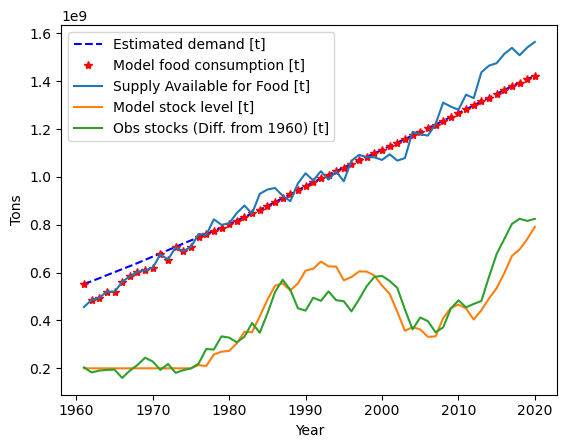

In [ ]:
plt.plot(years,1000*Pop_Data.Value.values[11:-3]*caloric_requirment/cereal_caloric_density*(1+processing),'b--',label='Estimated demand [t]')
plt.plot(years,alpha*1000*Pop_Data.Value.values[11:-3]*caloric_requirment/cereal_caloric_density*(1+processing),'r*',label='Model food consumption [t]')
plt.plot(years,Production_Data.Value.values[:-3]*(1-seed-loss-economic_use[0]),label='Supply Available for Food [t]')
plt.plot(years,stocks+stocks_obs[0]*1000,label='Model stock level [t]')
plt.plot(years,1000*np.array(stocks_obs)[1:-1-3],label='Obs stocks (Diff. from 1960) [t]')
#plt.plot(commodity_prices.Year.unique()[61:],1000*np.max(stocks_obs)*mean_price[61:],label='world price')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Tons')


In [ ]:
commodity_prices = pd.read_csv(r"C:/Users\danie\OneDrive\Desktop\M2 Internship\Data\trade\Geronimi-GYPrices-UpTo2020.csv")
commodity_prices.columns 

Index(['Year', 'Coffee', 'Cocoa', 'Tea', 'Rice', 'Wheat', 'Maize', 'Sugar',
       'Beef', 'Lamb', 'Banana', 'Palmoil', 'Cotton', 'Jute', 'Wool', 'Hides',
       'Tobacco', 'Rubber', 'Timber', 'Copper', 'Aluminum', 'Tin', 'Silver',
       'Lead', 'Zinc', 'MUV'],
      dtype='object')

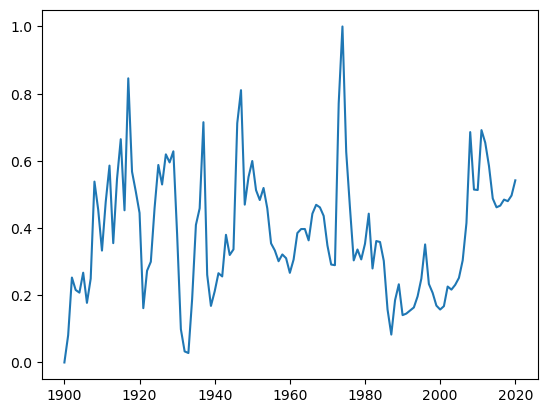

In [ ]:
from scipy.signal import detrend
world_avg_cereal_price = (commodity_prices['Maize']+commodity_prices['Rice']+commodity_prices['Wheat'])/(3*commodity_prices['MUV'])
world_avg_cereal_price = detrend(world_avg_cereal_price, type='linear')
norm_cereal_price = (world_avg_cereal_price-np.min(world_avg_cereal_price))/(-np.min(world_avg_cereal_price)+np.max(world_avg_cereal_price))
plt.plot(commodity_prices.Year,norm_cereal_price,label='World price [USD/ton]')

# 1-D SUM
- Adding regional units coupled by import/export relationships
- Specify animal use: attempt to reproduce relative stock levels
- then add monthly trade ?

### a. Regional disaggregation:
Main questions at this scale: 
1. simple representation of trade quantities? i.e. a linear relationship of stocks differences and a coefficient of trade openness


In [ ]:
#load data
UNSDA_conventions = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM\UNSD-NamingConventions.csv",delimiter=';')
UNSDA_conventions.loc[UNSDA_conventions["Intermediate Region Name"].isna(),"Intermediate Region Name"]=UNSDA_conventions.loc[UNSDA_conventions["Intermediate Region Name"].isna()]["Sub-region Name"]
UNSDA_conventions["Intermediate Region Name"].unique()
#UNSDA_conventions[UNSDA_conventions["ISO-alpha3 Code"]==national_animalfeed_use.Code.unique()[0]]["Intermediate Region Name"].values[0]

national_allocations = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM\FAOSTAT-OWID_bycountry-cereals-usage_1961-2022.csv")
regional_production = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM\FAOSTAT_regional-cereals-production_1961-2023.csv")
regional_trade =  pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM\FAOSTAT_regional-cereals-importexports_1961-2023.csv")
regional_population = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM\FAOSTAT_regional-population_1950-2023.csv")
region_mapping ={country:UNSDA_conventions[UNSDA_conventions["Country or Area"] == country]["Intermediate Region Name"].iloc[0] for country in UNSDA_conventions["Country or Area"].unique()}
national_allocations["Region"] = national_allocations['Entity'].map(region_mapping)

# Factual (i.e. FBS)

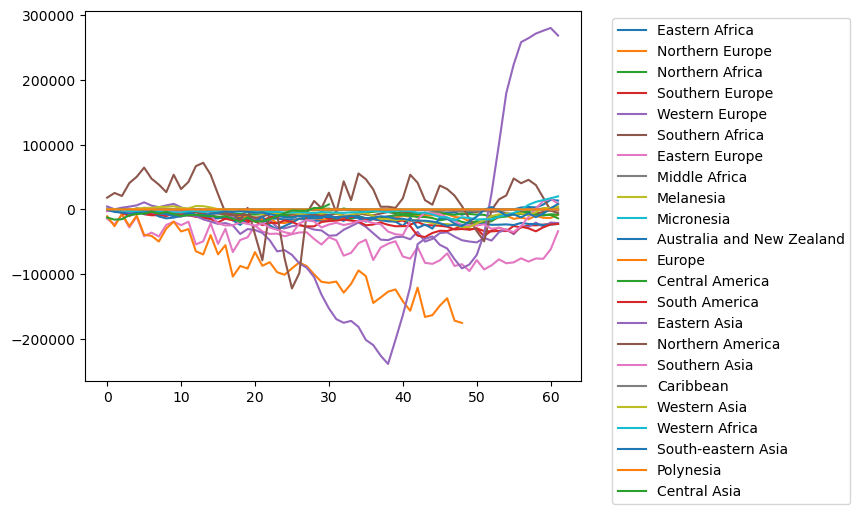

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Load the two CSV files
df_old = pd.read_csv('../Data/1DSUM/FAOSTAT_FBS-cereals-regional-1961-2013.csv')
df_new = pd.read_csv('../Data/1DSUM/FAOSTAT_FBS-cereals-regional-2010-2022.csv')

# Ensure 'Year' column is numeric
df_old['Year'] = pd.to_numeric(df_old['Year'], errors='coerce')
df_new['Year'] = pd.to_numeric(df_new['Year'], errors='coerce')

# Filter the old dataframe to include only years up to 2009
df_old_filtered = df_old[df_old['Year'] <= 2009]

# Combine the filtered old dataframe with the new dataframe
FAO_FBS_cereals = pd.concat([df_old_filtered, df_new], ignore_index=True)

# Optional: sort by year and reset index
FAO_FBS_cereals = FAO_FBS_cereals.sort_values(by='Year').reset_index(drop=True)
FAO_FBS_cereals['Element'].replace({"Import Quantity": "Import quantity", "Export Quantity": "Export quantity"}, inplace=True)
for country in FAO_FBS_cereals.Area.unique():
    plt.plot(np.cumsum(FAO_FBS_cereals[(FAO_FBS_cereals.Area == country) & (FAO_FBS_cereals.Element == "Stock Variation")]["Value"].values),label=country)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

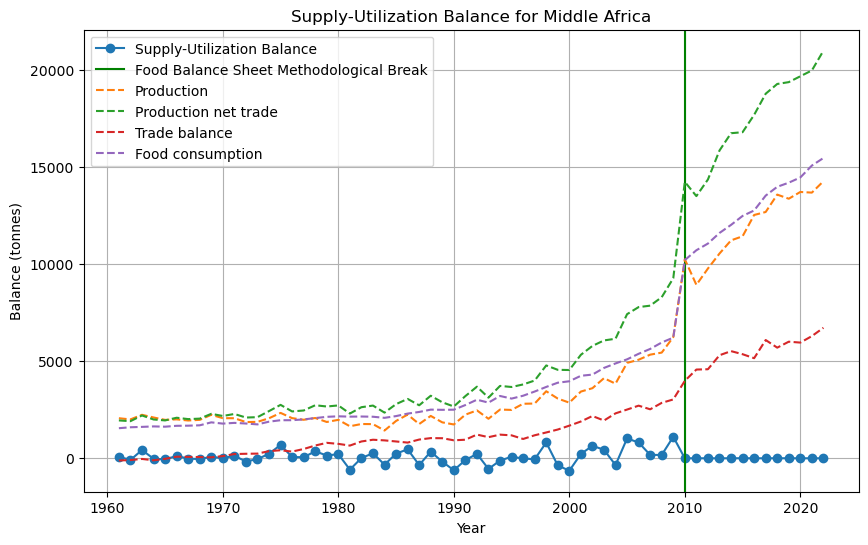

In [ ]:
# Filter the FAO_FBS_cereals dataframe for Melanesia
region = 'Middle Africa'
melanesia_data = FAO_FBS_cereals[FAO_FBS_cereals['Area'] == region]

residuals = np.zeros(len(melanesia_data.Year.unique()))
residuals[-len(melanesia_data[melanesia_data['Element'] == 'Residuals'].Value.values):] =melanesia_data[melanesia_data['Element'] == 'Residuals'].Value.values

# Calculate the supply-utilization balance
balance_data = (
    melanesia_data[melanesia_data['Element'] == 'Production']['Value'].values +
    melanesia_data[melanesia_data['Element'] == 'Import quantity']['Value'].values -
    melanesia_data[melanesia_data['Element'] == 'Export quantity']['Value'].values -
    melanesia_data[melanesia_data['Element'] == 'Stock Variation']['Value'].values -
    melanesia_data[melanesia_data['Element'] == 'Food']['Value'].values -
    melanesia_data[melanesia_data['Element'] == 'Feed']['Value'].values -
    melanesia_data[melanesia_data['Element'] == 'Processing']['Value'].values -
    melanesia_data[melanesia_data['Element'] == 'Other uses (non-food)']['Value'].values
    - melanesia_data[melanesia_data['Element'] == 'Losses']['Value'].values
    - melanesia_data[melanesia_data['Element'] == 'Seed']['Value'].values
    - residuals
    #- melanesia_data[melanesia_data['Element'] == 'Tourist consumption']['Value'].values
)

# Plot the balance over the years
plt.figure(figsize=(10, 6))
plt.plot(melanesia_data['Year'].unique(), balance_data, label='Supply-Utilization Balance', marker='o')
#plt.axhline(0, color='red', linestyle='--', label='Zero Balance')
#vertical line showing the food balance sheet methodloigcal break
plt.axvline(x=2010, color='green', linestyle='-', label='Food Balance Sheet Methodological Break')
#add lines for indivual components 
plt.plot(melanesia_data[melanesia_data['Element'] == 'Production']['Year'].values, melanesia_data[melanesia_data['Element'] == 'Production']['Value'].values, label='Production', linestyle='--')
#production net trade = production + import - export 
plt.plot(melanesia_data[melanesia_data['Element'] == 'Production']['Year'].values, melanesia_data[melanesia_data['Element'] == 'Production']['Value'].values + melanesia_data[melanesia_data['Element'] == 'Import quantity']['Value'].values - melanesia_data[melanesia_data['Element'] == 'Export quantity']['Value'].values, label='Production net trade', linestyle='--')
#trade balance
plt.plot(melanesia_data[melanesia_data['Element'] == 'Import quantity']['Year'].values, melanesia_data[melanesia_data['Element'] == 'Import quantity']['Value'].values - melanesia_data[melanesia_data['Element'] == 'Export quantity']['Value'].values, label='Trade balance', linestyle='--')
#Food consumption
plt.plot(melanesia_data[melanesia_data['Element'] == 'Food']['Year'].values, melanesia_data[melanesia_data['Element'] == 'Food']['Value'].values, label='Food consumption', linestyle='--')

plt.title('Supply-Utilization Balance for ' + region)
plt.xlabel('Year')
plt.ylabel('Balance (tonnes)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
year_data.Element

83                         Import quantity
84                         Stock Variation
86                         Export quantity
87                Domestic supply quantity
89                                    Feed
90                                  Losses
91                   Other uses (non-food)
93                                    Food
94     Food supply quantity (kg/capita/yr)
131          Food supply (kcal/capita/day)
Name: Element, dtype: object

In [ ]:
year_data[year_data.Element == "Production"]

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (FBS),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note


In [ ]:
import warnings 
warnings.filterwarnings('ignore')

# Initialize dictionaries to store time series data for each region
regional_time_series = {region: [] for region in FAO_FBS_cereals.Area.unique()[:-1]}

# Iterate over each region
for region in FAO_FBS_cereals.Area.unique()[:-1]:
    # Filter national allocations for the current region
    #region_data = national_allocations[national_allocations['Region'] == region]
    region_data = FAO_FBS_cereals[FAO_FBS_cereals.Area == region] 
    #print(region)
    region_frame = []
    # Iterate over each year in the dataset
    for year in region_data['Year'].unique():
        # Filter data for the current year
        year_data = region_data[region_data['Year'] == year]

        # Calculate the sum of food, animal feed, other, and processing
        total_allocation = year_data[year_data.Element == "Production"]["Value"].iloc[0] + year_data[year_data.Element == "Import quantity"]["Value"].iloc[0] - year_data[year_data.Element == "Export quantity"]["Value"].iloc[0] -  year_data[year_data.Element == "Stock Variation"]["Value"].iloc[0]
        production = year_data[year_data.Element == "Production"]["Value"].iloc[0]
        #total_allocation = year_data[year_data.Element == "Production"]["Value"].iloc[0] + year_data[year_data.Element == "Import quantity"]["Value"].iloc[0] - year_data[year_data.Element == "Export quantity"]["Value"].iloc[0]
        # Calculate proportions for each category
        food_proportion = (
            year_data[year_data.Element == "Food"]["Value"].iloc[0] / total_allocation
        )
        feed_proportion = (
            year_data[year_data.Element == "Feed"]["Value"].iloc[0] / total_allocation
        )
        other_proportion = (
            year_data[year_data.Element == "Other uses (non-food)"]["Value"].iloc[0] / total_allocation
        )
        processing_proportion = (
            year_data[year_data.Element == "Processing"]["Value"].iloc[0] / total_allocation
        )
        seed_proportion = (
            year_data[year_data.Element == "Seed"]["Value"].iloc[0] / production
        )
        loss_proportion = (
            year_data[year_data.Element == "Losses"]["Value"].iloc[0] / production
        )
        netfood_proportion = (
            year_data[year_data.Element == "Food"]["Value"].iloc[0] / (year_data[year_data.Element == "Feed"]["Value"].iloc[0] + year_data[year_data.Element == "Food"]["Value"].iloc[0] + year_data[year_data.Element == "Processing"]["Value"].iloc[0] +  year_data[year_data.Element == "Other uses (non-food)"]["Value"].iloc[0])   
        )
        try:
            residuals_proportion = (
                (year_data[year_data.Element == "Residuals"]["Value"].iloc[0] + year_data[year_data.Element == "Tourist consumption"]["Value"].iloc[0] ) / total_allocation
            )
        except: 
            try:
                residuals_proportion = (
                (year_data[year_data.Element == "Residuals"]["Value"].iloc[0]) / total_allocation
                )
            except:
                residuals_proportion =0
                #print(year)
            # if there is an error, set all proportions to NaN
            #Food, Feed, Other, Processing, Seed, Losses, Residuals = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        # Append the proportions as a dictionary to the regional time series
        region_frame.append({
            'Year': year,
            'Food': food_proportion,
            'Feed': feed_proportion,
            'Other': other_proportion,
            'Processing': processing_proportion,
            'Seed': seed_proportion,
            'Losses': loss_proportion,
            'Residuals': residuals_proportion,
            'NetFood' : netfood_proportion,
        })
# Convert the lists of dictionaries to DataFrames for each region
    regional_time_series[region] = pd.DataFrame(region_frame).sort_values(by='Year', ascending=True,ignore_index=True)

# Now we can calculate the mean proportions for each region
# Assuming regional_time_series is a dictionary of DataFrames by region:
regions = list(regional_time_series.keys())

# Initialize an empty DataFrame to hold the mean proportions
mean_proportions = pd.DataFrame(columns=["Food", "Feed", "Other", "Processing", "Seed", "Losses", "Residuals", "Total","NetFood"])

# Iterate through each region
for region in regions:
    if region in regional_time_series:
        region_df = regional_time_series[region]
        yearly_sum = region_df.groupby("Year").sum()
        region_mean = yearly_sum.std()
        
        food = region_mean.get("Food", 0)
        feed = region_mean.get("Feed", 0)
        other = region_mean.get("Other", 0)
        processing = region_mean.get("Processing", 0)
        seed = region_mean.get("Seed", 0)
        losses = region_mean.get("Losses", 0)
        residuals = region_mean.get("Residuals", 0)
        total = food + feed + other + processing + seed + losses + residuals
        netfood = region_mean.get("NetFood", 0)

        mean_proportions.loc[region] = {
            "Food": food,
            "Feed": feed,
            "Other": other,
            "Processing": processing,
            "Seed": seed,
            "Losses": losses,
            "Residuals": residuals,
            "Total": total,
            "NetFood": netfood
        }
    else:
        print(f"Warning: Region '{region}' not found in dataset.")

# Display the result
print(mean_proportions)

IndexError: single positional indexer is out-of-bounds

# Counterfactual
Trade and production data are most reliable. Next, we can assume that people need at least 1260 calories from cereals. What's left in the SUA is a mix of economic usage + stockage, which can be interpreted as agro-indusrty capital?


In [ ]:
USDAPSD_national_cereal_stocks = pd.read_csv(r"C:\Users\danie\Downloads\Untitled spreadsheet - USDA-PSD_national-eachcereals-beginningstocks_1960-2024.csv").ffill() #propogate forward missing values
not_current_countries = [
    "EU-15", "European Union", "Former Czechoslovakia", "Former Yugoslavia",
    "Serbia and Montenegro", "Union of Soviet Socialist Repu",
    "Yemen (Sanaa)", "Yemen (Aden)", "Yugoslavia (>05/92)"
] #either not a current state, or a state that has no data (Yemen aden and sanaa, manually verified. there is an independent entry for Yemen aggregated).
USDAPSD_national_cereal_stocks = USDAPSD_national_cereal_stocks[~USDAPSD_national_cereal_stocks["Country"].isin(not_current_countries)] #remove these countries from the dataset

In [ ]:
def map_us_convention_to_un_convention(country):
    # This function maps country names from the USDA PSD naming convention to the UN naming convention.
    # Gemeneni Pro 2.5 did this task really well, GPT 4.0 didn't. 
    # --- User's existing conditions ---
    if country == 'Czech Republic':
        country = 'Czechia'
    elif country == 'Congo (Kinshasa)':
        country = 'Democratic Republic of the Congo'
    elif country == 'Congo (Brazzaville)':
        # Assuming 'Congo' in the UN list refers to the Republic of the Congo
        country = 'Congo'
    elif country == 'Korea, South':
        country = 'Republic of Korea'
    elif country == 'Korea, North':
        country = "Democratic People's Republic of Korea"
    elif country == 'Taiwan': # UN does not list Taiwan separately
        country = 'China'
    elif country == 'Turkey':
        country = 'Türkiye'
    elif country == 'Vietnam':
        country = 'Viet Nam'
    elif country == 'Burma':
        country = 'Myanmar'
    elif country == "Cote d'Ivoire":
        # Note the different apostrophe and capitalization in the UN list
        country = 'Côte d’Ivoire'
    elif country == 'Gambia, The':
        country = 'Gambia'

    # --- New conditions based on list comparison ---
    elif country == 'Bolivia':
        country = 'Bolivia (Plurinational State of)'
    elif country == 'Brunei':
        country = 'Brunei Darussalam'
    elif country == 'Congo': # If the American list uses just 'Congo'
         # Assuming 'Congo' in the UN list refers to the Republic of the Congo
        country = 'Congo'
    elif country == 'Hong Kong':
        country = 'China, Hong Kong Special Administrative Region'
    elif country == 'Iran':
        country = 'Iran (Islamic Republic of)'
    elif country == 'Laos':
        country = "Lao People's Democratic Republic"
    elif country == 'Macau':
        country = 'China, Macao Special Administrative Region'
    elif country == 'Moldova':
        country = 'Republic of Moldova'
    elif country == 'Russia':
        country = 'Russian Federation'
    elif country == 'Syria':
        country = 'Syrian Arab Republic'
    elif country == 'Tanzania':
        country = 'United Republic of Tanzania'
    elif country == 'United Kingdom':
        country = 'United Kingdom of Great Britain and Northern Ireland'
    elif country == 'United States':
        country = 'United States of America'
    elif country == 'Venezuela':
        country = 'Venezuela (Bolivarian Republic of)'
    # Reunion needs accent correction if present in Am list (it was in UN list)
    elif country == 'Reunion':
         country = 'Réunion'
    # Add any other specific mappings needed based on your data source
    return country

In [ ]:
regional_cereals_stocks_obs = {region:np.zeros(len(USDAPSD_national_cereal_stocks.columns[3:-1])) for region in regional_production.Area.unique()}
rcs_years = {region:[] for region in regional_production.Area.unique()}
for country in USDAPSD_national_cereal_stocks.Country.unique():
    country_stocks = []    
    years = []
    for column in USDAPSD_national_cereal_stocks.columns[3:-1]:
        country_stocks.append(np.char.replace(USDAPSD_national_cereal_stocks[USDAPSD_national_cereal_stocks.Country==country][column].values.astype(str), ",", "").astype(float).sum())
        years.append(int(column[0:4]))
    country = map_us_convention_to_un_convention(country)
    region_of_country  = [region_mapping[key] for key in region_mapping.keys() if key.__contains__(country)][0] #slightly more complicated, but necessary because the dictionary keys sometimes contain more than the basic country name.
    rcs_years[region_of_country] = years
    regional_cereals_stocks_obs[region_of_country] += np.array(country_stocks)
#Convert to a pandas DataFrame for easier manipulation
# Build a list of rows
rows = []
for region in regional_cereals_stocks_obs:
    stocks = regional_cereals_stocks_obs[region]
    years = rcs_years[region]
    
    for stock, year in zip(stocks, years):
        rows.append({
            "region": region,
            "stock": stock,
            "Year": year
        })

# Convert list of rows into a DataFrame
regional_stocks_df = pd.DataFrame(rows)
    


FAOStat and USDA PSD cereal data on stocks disagree strongly: this is because of the high sensitivity of supply-utilization balance methodology to parameters of use like feed.
https://www.fao.org/fileadmin/templates/est/meetings/stocks/Abbott-Lessons_from_Recent_Stocks_Adjustments.pdf

In general, the suppply utilization balance is not a reliable empirical tool: it's in most cases strongly underidentified. However, we can consider a more theroetical case: agricultural capital. This is like a Solow-Model of agricultural sufficiency: there is savings, and "investment" which is not just in agriculture, but 

Text(0, 0.5, 'stocks')

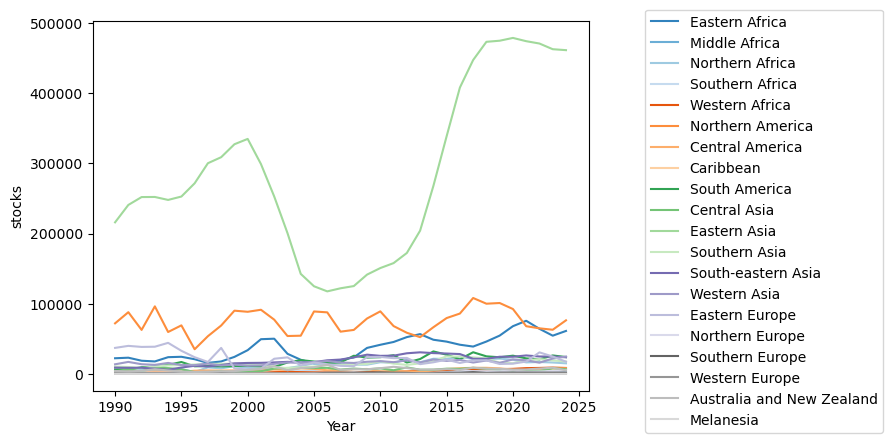

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
for r,region in enumerate(list(regional_cereals_stocks_obs.keys())[:-1]):
        plt.plot(rcs_years[region][30:],regional_cereals_stocks_obs[region][30:],label=region,color=colors[r])
        #plt.plot(FAO_FBS_cereals[(FAO_FBS_cereals.Element=="Stock Variation") & (FAO_FBS_cereals.Area==region) & (FAO_FBS_cereals.Year.isin(rcs_years[region][:]))]["Year"].values,regional_cereals_stocks_obs[region][0]+np.cumsum(FAO_FBS_cereals[(FAO_FBS_cereals.Element=="Stock Variation") & (FAO_FBS_cereals.Area==region) & (FAO_FBS_cereals.Year.isin(rcs_years[region][:]))]["Value"].values),label=region+" FAO",color=colors[r],linestyle='--')
        ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_xlabel('Year')
ax.set_ylabel('stocks')
 

In [ ]:
global_stock_ts = np.array(list(regional_cereals_stocks_obs.values())).sum(axis=0)[31:-2]
FAO_gsts= np.cumsum(-FAO_FBS_cereals[(FAO_FBS_cereals.Element=="Stock Variation") & (FAO_FBS_cereals.Year.isin(rcs_years[region][:]))].groupby("Year")["Value"].sum().values)

In [ ]:
FAO_national_cereal_stocks_changeregional_cereals_stocks_obs = {region:np.zeros(len(USDAPSD_national_cereal_stocks.columns[3:-1])) for region in regional_production.Area.unique()}
rcs_years = {region:[] for region in regional_production.Area.unique()}
for country in USDAPSD_national_cereal_stocks.Country.unique():
    country_stocks = []    
    years = []
    for column in USDAPSD_national_cereal_stocks.columns[3:-1]:
        country_stocks.append(np.char.replace(USDAPSD_national_cereal_stocks[USDAPSD_national_cereal_stocks.Country==country][column].values.astype(str), ",", "").astype(float).sum())
        years.append(int(column[0:4]))
    country = map_us_convention_to_un_convention(country)
    region_of_country  = [region_mapping[key] for key in region_mapping.keys() if key.__contains__(country)][0] #slightly more complicated, but necessary because the dictionary keys sometimes contain more than the basic country name.
    rcs_years[region_of_country] = years
    regional_cereals_stocks_obs[region_of_country] += np.array(country_stocks)
#Convert to a pandas DataFrame for easier manipulation
# Build a list of rows
rows = []
for region in regional_cereals_stocks_obs:
    stocks = regional_cereals_stocks_obs[region]
    years = rcs_years[region]
    
    for stock, year in zip(stocks, years):
        rows.append({
            "region": region,
            "stock": stock,
            "Year": year
        })

# Convert list of rows into a DataFrame
regional_stocks_df = pd.DataFrame(rows)
    

#### Testing chronic food undersupply

In [ ]:
seed = 0.03
loss = 0.04
processing = 0.04
economic_use = 0.33  + 0.08+addit# 0*np.hstack([World_otheruse,World_otheruse[-1]])/100 # 35% for animal consumption. World other use is extended by one year. #
cereal_caloric_density = 2609*1000 # kcal/ton 
caloric_requirment = 1240*365 # 1200 kcal/year

years = regional_production.Year.unique()
years = years[30:-3]

stocks = np.zeros((len(regional_production.Area.unique()),len(years)))-0.01
percapita_stocks = np.zeros((len(regional_production.Area.unique()),len(years)))-0.01


alpha = np.ones((len(regional_production.Area.unique()),len(years)))
for r,region in enumerate(regional_production.Area.unique()[0:-1]):
    #stocks[r,0] = regional_stocks_df[(regional_stocks_df.region == region) & (regional_stocks_df.Year == years[0])].stock.values*1000 # tons
    seed = 0.03
    loss = 0.04
    cereal_caloric_density = 2609*1000 # kcal/ton 
    caloric_requirment = 1240*365 # 1200 kcal/year
    stocks[r,0] = regional_cereals_stocks_obs[region][30]*1000
    for i in np.arange(1,len(years)):
        #food_supply = regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Food
        #seed = regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Losses
        #loss = regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Seed
        processing = 0# regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Processing
        economic_use = 0#regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Other + regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Feed
        Pop = 1000*regional_population[(regional_population.Year == years[i]) & (regional_population.Area == region )].Value.values[0] #[1000 people]
        residuals = 0#regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Residuals
        Y = regional_production[(regional_production.Year == years[i]) & (regional_production.Area == region )].Value.values[0] #[tons]
        stock_use_ratio = 1-norm_cereal_price[commodity_prices.Year ==years[i]]
        
        try:
            trade_balance = regional_trade[(regional_trade.Year == years[i]) & (regional_trade.Area == region ) & (regional_trade.Element == 'Import quantity')].Value.values[0] - regional_trade[(regional_trade.Year == years[i]) & (regional_trade.Area == region ) & (regional_trade.Element == 'Export quantity')].Value.values[0] #[tons]
            world_pop = np.sum(regional_population[(regional_population.Year == years[i])].Value.values)
            #trade_balance = (np.delete(stocks[:,i-1],r).sum()- stocks[r,i-1]) * (0.1)
        except:
            trade_balance =0 
            print(region)
            #print(years[i])
        if region == 'Northern America':
            economic_use=economic_use#+0.4 #if lots of beer is produced
            #trade_balance = 1*(regional_trade[(regional_trade.Year == years[i]) & (regional_trade.Area == region ) & (regional_trade.Element == 'Import quantity')].Value.values[0] - 2*regional_trade[(regional_trade.Year == years[i]) & (regional_trade.Area == region ) & (regional_trade.Element == 'Export quantity')].Value.values[0]) #[tons]
        food = Pop*caloric_requirment/cereal_caloric_density # in tons
        total_supply = Y+trade_balance
        if stocks[r,i-1] + trade_balance + (Y*(1-seed-loss) - alpha[r,i]*food*(1+processing) - total_supply*economic_use) > 0:
            alpha[r,i] = 1
        else:
            alpha[r,i] = (stocks[r,i-1] + trade_balance + Y*(1-seed-loss) - total_supply*economic_use)/(food*(1+processing))
            alpha[r,i] = alpha[r,i].clip(0,1)
        dstock = trade_balance + Y*(1-seed-loss) - alpha[r,i]*food - total_supply*(economic_use+processing+residuals)
        stocks[r,i] = stocks[r,i-1] + dstock #- stocks[r,i-1]*0.33 #*stock_use_ratio #- 0.1*stocks[r,i-1] # 10% of the stocks are lost each year
        percapita_stocks[r,i] = stocks[r,i]/Pop



Text(0, 0.5, 'alpha')

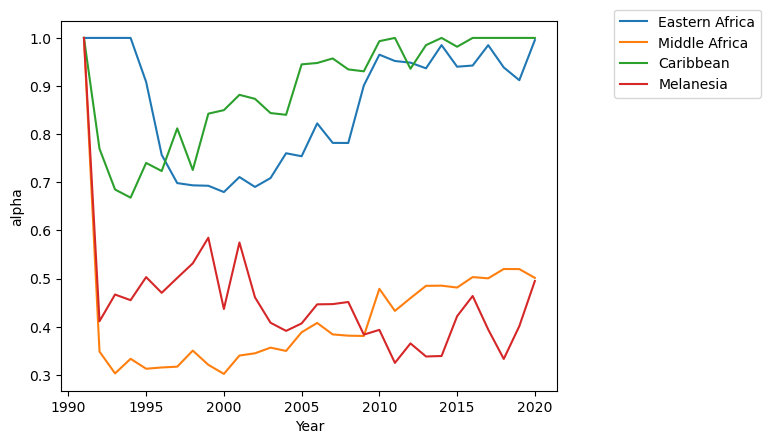

In [ ]:


colors = plt.cm.tab20c.colors  # 20 colors, plus an additional one from the "tab20c" colormap
# Make sure that there are 21 colors by repeating the last one if needed
colors = list(colors) + [colors[-1]]
fig = plt.figure()
ax = plt.subplot(111)

for r,region in enumerate(regional_production.Area.unique()):
    if alpha[r,:].mean()<1: #(region == "Western Africa"):
        plt.plot(years,alpha[r,:],label=region)#color=colors[r])
        ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_xlabel('Year')
ax.set_ylabel('alpha')


In [ ]:
FAO_FBS_cereals.Area.unique()


array(['Eastern Africa', 'Northern Europe', 'Northern Africa',
       'Southern Europe', 'Western Europe', 'Southern Africa',
       'Eastern Europe', 'Middle Africa', 'Melanesia', 'Micronesia',
       'Australia and New Zealand', 'Europe', 'Central America',
       'South America', 'Eastern Asia', 'Northern America',
       'Southern Asia', 'Caribbean', 'Western Asia', 'Western Africa',
       'South-eastern Asia', 'Polynesia', 'Central Asia'], dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Year')

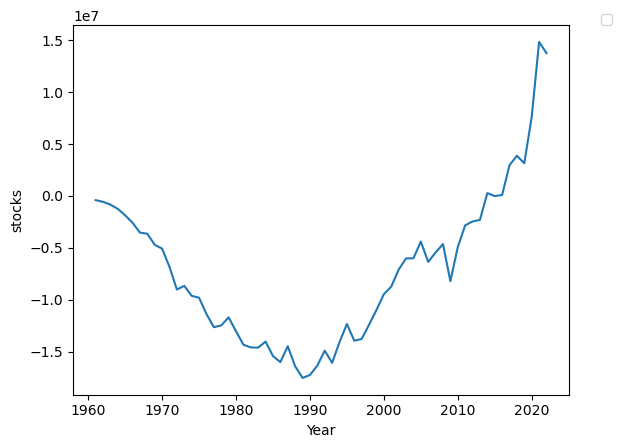

In [ ]:

#plt.plot(years,np.sum(stocks[:-1,:],axis=0),color=colors[r],label="World Stocks (model)")
#FAO_gsts= 1000*np.cumsum(FAO_FBS_cereals[(FAO_FBS_cereals.Element=="Stock Variation") & (FAO_FBS_cereals.Year.isin(years))].groupby("Year")["Value"].sum().values)
FAO_gsts= 1000*np.cumsum(FAO_FBS_cereals[(FAO_FBS_cereals.Area=="Eastern Africa")&(FAO_FBS_cereals.Element=="Stock Variation")].groupby("Year")["Value"].sum().values)

plt.plot(FAO_FBS_cereals.Year.unique(),FAO_gsts)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel('stocks')
plt.xlabel('Year')

#### analyze correlations in trade with production 

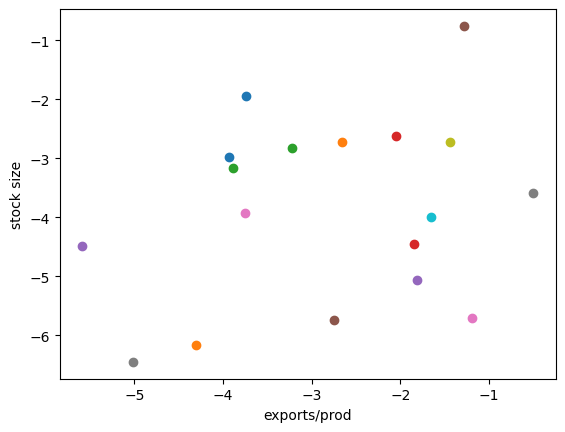

In [ ]:
import scipy.signal
for region_of_interest,region_name in enumerate(regional_production.Area.unique()[0:-2]):
    #
    if region_name != "Eastern Asia":
        exports= regional_trade[(regional_trade.Area == regional_production.Area.unique()[region_of_interest] ) & (regional_trade.Element == 'Export quantity')].Value.values 
        imports = regional_trade[(regional_trade.Area == regional_production.Area.unique()[region_of_interest] ) & (regional_trade.Element == 'Import quantity')].Value.values 
        prod = regional_production[(regional_production.Area == regional_production.Area.unique()[region_of_interest]) & (regional_production.Element == 'Production')].Value.values
        trade_balance = imports-exports
        #
        region_stocks = regional_cereals_stocks_obs[region_name]
        maxstock = np.max([stock.mean() for stock in regional_cereals_stocks_obs.values()])
        stock_difference = np.zeros(len(region_stocks))

    # for r in range(len(regional_production.Area.unique()[0:-1])):
    #     if r != region_of_interest:
    #         stock_difference= stock_difference +stocks[r,:]

        #stock_difference = stock_difference - stocks[region_of_interest,:]

        #plt.plot(stock_difference,trade_balance[30:-1],label=region_name)
        variable1 = exports  
        variable2 = prod
        #plt.plot(exports/prod)
        correlation =np.corrcoef(scipy.signal.detrend(variable1),scipy.signal.detrend(variable2))[0,1]
        #plt.scatter(scipy.signal.detrend(variable1),scipy.signal.detrend(variable2),label=region_name+" R2="+str(round(correlation,2)))
        #oddly enough, in Eastern and Middle Africa, production of cereals is quite correlated with imports of cereals. This is obviously not expected.
        #the ratio of imports or exports to production is actually only around 0.2/0.1 in Middle/Eastern Africa, which is not that high compared to 0.65 in Northern Africa. its like 0.2 in western europe.
        #print(region_name)
        #print(np.mean(np.round(exports/prod,3)))
        plt.scatter(np.log(np.mean(np.round(exports/prod,3))),np.log(region_stocks.mean()/maxstock),label=region_name)
        #plt.legend()
        plt.xlabel('exports/prod')
        plt.ylabel('stock size')

### a. National disaggregation:
Main assumptions:
1. Trade is exogenous (as it appears to be -- without analysis -- in the regional data)

Main questions at this scale: 
1. 


In [ ]:
FoodConsumptionSurveyShares["Food Group"].unique()

array(['All food groups', 'Cereals and their products'], dtype=object)

In [ ]:
#Food Survey Consumption Share data analysis
FoodConsumptionSurveyShares = pd.read_csv(r"..\Data\1DSUM\FAOSTAT_Intake-national-surveys.csv")
def split_names(name):
    try: 
      name = int(name.split("-")[1])
    except:
      name = int(name.split("-")[2])
    return name
FoodConsumptionSurveyShares["Country"] = [name.split("-")[0] for name in FoodConsumptionSurveyShares["Survey"].values]
FoodConsumptionSurveyShares["Year"] = [split_names(name) for name in FoodConsumptionSurveyShares["Survey"].values]

cereal_ratios = []
all_cons =[]
for country in FoodConsumptionSurveyShares["Country"].unique():
    if np.sum((FoodConsumptionSurveyShares["Country"]==country)*(FoodConsumptionSurveyShares["Food Group"]=='All food groups')) > 1:
        print(country)
        
        all_food_cons = FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='All food groups')].Value
        all_food_cons_diff = FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='All food groups')].Value.iloc[1] - FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='All food groups')].Value.iloc[0]
        
        cereal_cons = FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='Cereals and their products')].Value
        cereal_cons_diff = FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='Cereals and their products')].Value.iloc[1] - FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='Cereals and their products')].Value.iloc[0]
        print("all food consumption")
        print(all_food_cons)
        print("cereal consumption")
        print(cereal_cons)
        print(FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='All food groups')].Year.values)
        cereal_ratio = (cereal_cons/all_food_cons)
        cereal_ratios.append(cereal_ratio)
        #all_cons.append(all_food_cons)

#These changes in caloric intake, both total and of cereals, are not reflected in the FAO food availabiliy data. at best a third is reflected.

Armenia 
all food consumption
4     1765
6     1824
8     1934
10    1746
Name: Value, dtype: int64
cereal consumption
5     879
7     907
9     915
11    846
Name: Value, dtype: int64
[2019 2020 2021 2022]
Bangladesh 
all food consumption
12    2190
14    2095
Name: Value, dtype: int64
cereal consumption
13    1576
15    1367
Name: Value, dtype: int64
[2010 2016]
Benin 
all food consumption
16    2653
18    2688
Name: Value, dtype: int64
cereal consumption
17     922
19    1045
Name: Value, dtype: int64
[2019 2022]
Burkina Faso 
all food consumption
22    2071
24    1967
Name: Value, dtype: int64
cereal consumption
23    1180
25    1022
Name: Value, dtype: int64
[2019 2022]
Côte d'Ivoire 
all food consumption
30    2110
32    2010
Name: Value, dtype: int64
cereal consumption
31    727
33    703
Name: Value, dtype: int64
[2019 2022]
Ethiopia 
all food consumption
34    2394
36    2327
Name: Value, dtype: int64
cereal consumption
35    1568
37    1453
Name: Value, dtype: int64
[2016 201

# Empirical Drivers of Undernutrition Changes in Middle, West, and Middle Africa last twenty years.
going beyond a 'residual accumulation of errors' (hays 1978)

In [ ]:
National_Roads = pd.read_csv(r"..\Data\1DSUM-National\EHDR_Replication_Files\roads+rails_all-1960-2015.csv")
National_LandArea = pd.read_excel(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM-National\EHDR_Replication_Files\area.xls")

In [ ]:
# Forecast paved and rail_km for years 2016-2023 using linear fitting on 2011-2015 data.
forecast_rows = []
# Assuming your National_Roads dataframe contains a column named "Country". 
for country, group in National_Roads.groupby("country"):
    # Select training data for 2011-2015
    train = group[(group['year'] >= 2011) & (group['year'] <= 2015)]
    # Ensure there are enough data points
    if train.shape[0] < 2:
        continue  # skip countries with insufficient data
    # Fit a linear model for each variable
    coeffs_paved = np.polyfit(train['year'], train['paved'], 1)
    coeffs_rail = np.polyfit(train['year'], train['rail_km'], 1)
    # Forecast for years 2016 to 2023
    for yr in range(2016, 2024):
        paved_pred = np.polyval(coeffs_paved, yr)
        rail_pred = np.polyval(coeffs_rail, yr)
        forecast_rows.append({
            "country": country,
            "year": yr,
            "paved": paved_pred,
            "rail_km": rail_pred
            # add any other fields necessary; if in your original data there are additional columns,
            # consider adding them here (or leave them as NaN)
        })
forecast_df = pd.DataFrame(forecast_rows)
print(forecast_df.head())

# To append to your original National_Roads dataframe:
National_Roads_extended = pd.concat([National_Roads, forecast_df], ignore_index=True)
print(National_Roads_extended.tail())

  country  year        paved      rail_km
0  Angola  2016  9167.015179  3097.292221
1  Angola  2017  9167.015179  3097.292221
2  Angola  2018  9167.015179  3097.292221
3  Angola  2019  9167.015179  3097.292221
4  Angola  2020  9167.015179  3097.292221
      Unnamed: 0   country  year      rail_km  map  highway        paved  \
2747         NaN  Zimbabwe  2019  2633.235571  NaN      NaN  8394.522391   
2748         NaN  Zimbabwe  2020  2633.235571  NaN      NaN  8394.522391   
2749         NaN  Zimbabwe  2021  2633.235571  NaN      NaN  8394.522391   
2750         NaN  Zimbabwe  2022  2633.235571  NaN      NaN  8394.522391   
2751         NaN  Zimbabwe  2023  2633.235571  NaN      NaN  8394.522391   

      improved  paved2  pavimp  lhighway  lpaved  limproved  lpaved2  lpavimp  \
2747       NaN     NaN     NaN       NaN     NaN        NaN      NaN      NaN   
2748       NaN     NaN     NaN       NaN     NaN        NaN      NaN      NaN   
2749       NaN     NaN     NaN       NaN     NaN

In [ ]:
africa_mapping = {
    "Angola": "Angola",
    "Benin": "Benin",
    "Burkina Faso": "Burkina Faso",
    "Burundi": "Burundi",
    "Cabo Verde": "Cabo Verde",
    "Cameroon": "Cameroon",
    "Central African Republic": "Central African Republic",
    "Chad": "Chad",
    "Comoros": "Comoros",
    "Congo, Rep.": "Congo",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Congo, Dem. Rep.": "Democratic Republic of the Congo",
    "Djibouti": "Djibouti",
    "Equatorial Guinea": "Equatorial Guinea",
    "Eritrea": "Eritrea",
    "Ethiopia": "Ethiopia",
    "Gabon": "Gabon",
    "Gambia, The": "Gambia",
    "Ghana": "Ghana",
    "Guinea": "Guinea",
    "Guinea-Bissau": "Guinea-Bissau",
    "Kenya": "Kenya",
    "Liberia": "Liberia",
    "Madagascar": "Madagascar",
    "Malawi": "Malawi",
    "Mali": "Mali",
    "Mauritania": "Mauritania",
    "Mauritius": "Mauritius",
    "Mozambique": "Mozambique",
    "Niger": "Niger",
    "Nigeria": "Nigeria",
    "Rwanda": "Rwanda",
    "Sao Tome and Principe": "Sao Tome and Principe",
    "Senegal": "Senegal",
    "Seychelles": "Seychelles",
    "Sierra Leone": "Sierra Leone",
    "Somalia": "Somalia",
    "South Sudan": "South Sudan",
    "Togo": "Togo",
    "Uganda": "Uganda",
    "Tanzania": "United Republic of Tanzania",
    "Zambia": "Zambia",
    "Zimbabwe": "Zimbabwe"
}
africa_mapping_reversed = {v: k for k, v in africa_mapping.items()}
print(africa_mapping_reversed)

{'Angola': 'Angola', 'Benin': 'Benin', 'Burkina Faso': 'Burkina Faso', 'Burundi': 'Burundi', 'Cabo Verde': 'Cabo Verde', 'Cameroon': 'Cameroon', 'Central African Republic': 'Central African Republic', 'Chad': 'Chad', 'Comoros': 'Comoros', 'Congo': 'Congo, Rep.', "Côte d'Ivoire": "Cote d'Ivoire", 'Democratic Republic of the Congo': 'Congo, Dem. Rep.', 'Djibouti': 'Djibouti', 'Equatorial Guinea': 'Equatorial Guinea', 'Eritrea': 'Eritrea', 'Ethiopia': 'Ethiopia', 'Gabon': 'Gabon', 'Gambia': 'Gambia, The', 'Ghana': 'Ghana', 'Guinea': 'Guinea', 'Guinea-Bissau': 'Guinea-Bissau', 'Kenya': 'Kenya', 'Liberia': 'Liberia', 'Madagascar': 'Madagascar', 'Malawi': 'Malawi', 'Mali': 'Mali', 'Mauritania': 'Mauritania', 'Mauritius': 'Mauritius', 'Mozambique': 'Mozambique', 'Niger': 'Niger', 'Nigeria': 'Nigeria', 'Rwanda': 'Rwanda', 'Sao Tome and Principe': 'Sao Tome and Principe', 'Senegal': 'Senegal', 'Seychelles': 'Seychelles', 'Sierra Leone': 'Sierra Leone', 'Somalia': 'Somalia', 'South Sudan': 'Sout

In [ ]:
National_Cereals_Production.Area.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bangladesh', 'Barbados',
       'Belarus', 'Belgium', 'Belgium-Luxembourg', 'Belize', 'Benin',
       'Bhutan', 'Bolivia (Plurinational State of)',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile',
       'China, Hong Kong SAR', 'China, mainland',
       'China, Taiwan Province of', 'Colombia', 'Comoros', 'Congo',
       'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Cyprus',
       'Czechia', 'Czechoslovakia',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Eritrea', 'Estonia', 'Eswatini', 'Ethio

In [ ]:
cereal_caloric_density = 2609*1000 # kcal/ton 
caloric_requirment = 1240*365 # 1200 kcal/year

#0. load data
#a) FAOStat Agricultural Data
National_Income = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-income_1970-2022.csv")
National_Trade = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-cereals-importexports-1961-2023.csv")
National_AgEmpShares = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-employmentsharesagriculture-2000-2021.csv")
National_Populations = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-population+ruralurban_1950-2023.csv")
National_Cereals_Production = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-cereals-production_1961-2023.csv")
#b) FAOStat Food Security Indicators 
National_Food_Security_Indicators = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_4FoodSecurityIndicators-SSA-MinusSouthAfrica.csv")
original_data = National_Food_Security_Indicators["Year"].unique()
#Replace the items labeled by a three year average with the central year value, for better intercomparability.  Use a dictionary comprehension, assuming clean data ('YYYY-YYYY+2' format for ranges)
replace_map = {
    item: str(int(item.split('-')[0]) + 1)  # value: Calculate central year string
    for item in original_data               # iterate over each element
    if isinstance(item, str) and '-' in item # condition: element is a string & contains hyphen
}
National_Food_Security_Indicators["Year"].replace(replace_map, inplace=True) # replace values in the DataFrame
#Fill incomplete rail line density data
National_Food_Security_Indicators[National_Food_Security_Indicators["Item"]=='Rail lines density (total route in km per 100 square km of land area)'].ffill()

# c) Convert Year columns in all dataframes to integer
print("Converting 'Year' columns to integer...")
for df_name, df in [('IncomeAg', National_Income), ('Trade', National_Trade),
                     ('AgEmpShares', National_AgEmpShares), ('Populations', National_Populations),
                     ('Cereals', National_Cereals_Production),('FSI',National_Food_Security_Indicators)]:
    if 'Year' in df.columns:
        df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
        df.dropna(subset=['Year'], inplace=True)
        df['Year'] = df['Year'].astype(int)
    else:
        print(f"Warning: 'Year' column not found in {df_name}")
print("'Year' column conversion complete.")

#2. Get a list of all variables to be used in the time series matrix. 

all_variables = ['Road Density','Rural Pop. Percent','Cereals Production (per Capita)','Cereals Trade Balance (per Capita)','GDP (per Capita)','Conflict Index','Share of AFS employment in total employment','Share of agricultural employment in total AFS employment','Gross National Income (per Capita, USD)','Cereals Production Net Trade (kcal/capita/day)']#all variable names here: one for each of the first five (national_incomeag,...NAtional_cereals_Production), except for IncomeAg the first one, which has two different items. Also Trade has imports and exports (two seperate items) from which I want just a variable for the trade balance. Also Populations has both toal populations and rural/urban population. I want just one from that one: rural population/total population. Essentially can do item.unique if needed

#also, the below code should normalize to a per capita basis the trade balance and production 
#target_timeseries = np.zeros((len(National_Food_Security_Indicators.Area.unique()),len(National_Food_Security_Indicators.Year.unique())))

#2.here we combine all the variables into a single time series matrix 

areas = National_Food_Security_Indicators['Area'].unique()
years = National_Food_Security_Indicators['Year'].unique()
data_timeseries = np.zeros((len(all_variables),len(areas),len(years)))

def get_total_population(area, year):
    df_tot = National_Populations[(National_Populations['Area'] == area) &
                                  (National_Populations['Year'] == year) &
                                  (National_Populations['Element'] == 'Total Population - Both sexes')]
    if not df_tot.empty:
        pop = df_tot['Value'].iloc[0]
        if '1000' in df_tot['Unit'].iloc[0]:
            pop *= 1000
        return pop
    return np.nan

def get_rural_population(area, year):
    df_rural = National_Populations[(National_Populations['Area'] == area) &
                                    (National_Populations['Year'] == year) &
                                    (National_Populations['Element'] == 'Rural population')]
    if not df_rural.empty:
        pop = df_rural['Value'].iloc[0]
        if '1000' in df_rural['Unit'].iloc[0]:
            pop *= 1000
        return pop
    return np.nan

# Loop over areas and years to fill the matrix.
# We assume that:
#   - all_variables is defined as:
#       ['Rail Density','Rural Pop. Percent','Cereals Production (per Capita)',
#        'Cereals Trade Balance (per Capita)','GDP (per Capita)','Conflict Index',
#        'Income (per Capita)','Share of AFS employment in total employment',
#        'Share of agricultural employment in total AFS employment',
#        'Gross National Income (per Capita, USD)']
#   - data_timeseries has been initialized with shape (len(all_variables), num_areas, num_years)
#   - The following DataFrames are loaded:
#       National_Food_Security_Indicators, National_Populations, National_Cereals_Production,
#       National_Trade, National_IncomeAg, National_AgEmpShares

for j, area in enumerate(areas):
    for k, year in enumerate(years):
        for i, variable in enumerate(all_variables):
            value = np.nan  # default
            if variable == 'Rail Density':
                # Look in Food Security Indicators by matching Item text.
                df = National_Roads_extended[(National_Roads_extended['country'] == area) &
                                                       (National_Roads_extended['year'] == year)]["rail_km"]
                if not df.empty:
                    tot = get_total_population(area, year)
                    if not np.isnan(tot) and tot != 0:    
                        landarea = National_LandArea[(National_LandArea['country'] == africa_mapping_reversed[area]) & (National_LandArea.series == 'Land area (sq. km)')]["y2015"].iloc[0]
                        value = (df.iloc[0]/landarea)/tot
            elif variable == 'Road Density':
                # Look in Food Security Indicators by matching Item text.
                df = National_Roads_extended[(National_Roads_extended['country'] == area) &
                                                       (National_Roads_extended['year'] == year)]["paved"]
                if not df.empty:
                    tot = get_total_population(area, year)
                    if not np.isnan(tot) and tot != 0:
                        landarea = National_LandArea[(National_LandArea['country'] == africa_mapping_reversed[area]) & (National_LandArea.series == 'Land area (sq. km)')]["y2015"].iloc[0]
                        value = (df.iloc[0]/landarea)

            elif variable == 'Rural Pop. Percent':
                tot = get_total_population(area, year)
                rural = get_rural_population(area, year)
                if not np.isnan(tot) and tot != 0:
                    value = (rural / tot) * 100

            elif variable == 'Cereals Production (per Capita)':
                # Get cereals production (assume Element == 'Production') and divide by total population.
                df_prod = National_Cereals_Production[(National_Cereals_Production['Area'] == area) &
                                                       (National_Cereals_Production['Year'] == year) &
                                                       (National_Cereals_Production['Element'] == 'Production')]
                tot = get_total_population(area, year)
                if (not df_prod.empty) and (not np.isnan(tot)) and tot != 0:
                    prod = df_prod['Value'].iloc[0]
                    value = prod / tot
            
            elif variable == 'Cereals Trade Balance (per Capita)':
                # Retrieve import and export quantities from National_Trade
                df_imp = National_Trade[(National_Trade['Area'] == area) &
                                        (National_Trade['Year'] == year) &
                                        (National_Trade['Element'] == 'Import quantity')]
                df_exp = National_Trade[(National_Trade['Area'] == area) &
                                        (National_Trade['Year'] == year) &
                                        (National_Trade['Element'] == 'Export quantity')]
                tot = get_total_population(area, year)
                if (not df_imp.empty) and (not df_exp.empty) and (not np.isnan(tot)) and tot != 0:
                    imp = df_imp['Value'].iloc[0]
                    exp = df_exp['Value'].iloc[0]
                    balance = imp - exp
                    value = balance / tot
            
            elif variable == 'GDP (per Capita)':
                # Use GDP value from Food Security Indicators.
                df_gdp = National_Food_Security_Indicators[(National_Food_Security_Indicators['Area'] == area) &
                                                           (National_Food_Security_Indicators['Year'] == year) &
                                                           (National_Food_Security_Indicators['Item'] ==
                                                            'Gross domestic product per capita, PPP, (constant 2017 international $)')]
                if not df_gdp.empty:
                    value = df_gdp['Value'].iloc[0]

            elif variable == 'Conflict Index':
                df_conf = National_Food_Security_Indicators[(National_Food_Security_Indicators['Area'] == area) &
                                                            (National_Food_Security_Indicators['Year'] == year) &
                                                            (National_Food_Security_Indicators['Item'] ==
                                                             'Political stability and absence of violence/terrorism (index)')]
                if not df_conf.empty:
                    value = df_conf['Value'].iloc[0]
        
            elif variable == 'Share of AFS employment in total employment':
                # Use the indicator available in National_AgEmpShares.
                df_emp = National_AgEmpShares[(National_AgEmpShares['Area'] == area) &
                                              (National_AgEmpShares['Year'] == year) &
                                              (National_AgEmpShares['Indicator'] == 'Share of AFS employment in total employment') &
                                              (National_AgEmpShares['Sex'] == 'Total')]
                if not df_emp.empty:
                    value = df_emp['Value'].iloc[0]
            
            elif variable == 'Share of agricultural employment in total AFS employment':
                # Use the indicator in National_AgEmpShares; here we choose (for example) the female data.
                df_emp2 = National_AgEmpShares[(National_AgEmpShares['Area'] == area) &
                                               (National_AgEmpShares['Year'] == year) &
                                               (National_AgEmpShares['Indicator'] == 'Share of employment in agriculture in total employment') &
                                               (National_AgEmpShares['Sex'] == 'Female')]
                if not df_emp2.empty:
                    value = df_emp2['Value'].iloc[0]
            
            elif variable == 'Gross National Income (per Capita, USD)':
                # Similarly, retrieve GNI from National_IncomeAg.
                df_gni = National_Income[(National_Income['Area'] == area) &
                                           (National_Income['Year'] == year) &
                                           (National_Income['Item'] == 'Gross National Income')]
                if not df_gni.empty:
                    value = df_gni['Value'].iloc[0]
            elif variable == 'Cereals Production Net Trade (kcal/capita/day)':
                #Get cereals production (assume Element == 'Production') + trade balance (assume Element == 'Net Trade') and divide by total population.
                df_prod = National_Cereals_Production[(National_Cereals_Production['Area'] == area) &
                                                       (National_Cereals_Production['Year'] == year) &
                                                       (National_Cereals_Production['Element'] == 'Production')]    
                df_imp = National_Trade[(National_Trade['Area'] == area) &
                                        (National_Trade['Year'] == year) &
                                        (National_Trade['Element'] == 'Import quantity')]
                df_exp = National_Trade[(National_Trade['Area'] == area) &
                                        (National_Trade['Year'] == year) &
                                        (National_Trade['Element'] == 'Export quantity')]
                tot = get_total_population(area, year)
                if (not df_prod.empty) and (not df_imp.empty) and (not df_exp.empty) and (not np.isnan(tot)) and tot != 0:
                    # Calculate net trade as imports - exports
                    imp = df_imp['Value'].iloc[0]
                    exp = df_exp['Value'].iloc[0]
                    balance = imp - exp
                    prod = df_prod['Value'].iloc[0]
                    value = (cereal_caloric_density*(prod + balance) / tot)/365 # kcal/person/day
            # Assign the computed value (or np.nan if unavailable)
            data_timeseries[i, j, k] = float(value)
    print("Processed data for " + area)
# Optionally, print summary of the filled matrix:
print("Data timeseries matrix filled with shape:", data_timeseries.shape)

###
# Create a timeseries for the indicator "Prevalence of undernourishment (percent) (3-year average)"
#indicator = "Prevalence of undernourishment (percent) (3-year average)"
# Filter the dataset for the indicator. Using str.contains to be flexible.
#df_under = National_Food_Security_Indicators[National_Food_Security_Indicators["Item"].str.contains("Prevalence of undernourishment", case=False)]
df_under = National_Food_Security_Indicators[National_Food_Security_Indicators["Item"].str.contains("Coefficient of variation", case=False)]

# Check the dimensions (we expect 43 areas and 23 years)
print("Found", len(areas), "areas and", len(years), "years.")

# Initialize the timeseries array with np.nan (shape: 1 x (# areas) x (# years))
undernourishment_timeseries = np.full((1, len(areas), len(years)), np.nan)

# Fill the timeseries array by iterating over areas and years.
for i, area in enumerate(areas):
    for j, year in enumerate(years):
        # Filter for the given area and year.
        temp = df_under[(df_under["Area"] == area) & (df_under["Year"] == year)]["Value"]
        if not temp.empty:
            if temp.values[0]=='<2.5':
                undernourishment_timeseries[0, i, j] = 0
            else:
                undernourishment_timeseries[0, i, j]  = float(temp.values[0])
# Verify the shape.
print("undernourishment_timeseries complete with shape:", undernourishment_timeseries.shape)

Converting 'Year' columns to integer...
'Year' column conversion complete.
Processed data for Angola
Processed data for Benin
Processed data for Burkina Faso
Processed data for Burundi
Processed data for Cabo Verde
Processed data for Cameroon
Processed data for Central African Republic
Processed data for Chad
Processed data for Comoros
Processed data for Congo
Processed data for Côte d'Ivoire
Processed data for Democratic Republic of the Congo
Processed data for Djibouti
Processed data for Equatorial Guinea
Processed data for Eritrea
Processed data for Ethiopia
Processed data for Gabon
Processed data for Gambia
Processed data for Ghana
Processed data for Guinea
Processed data for Guinea-Bissau
Processed data for Kenya
Processed data for Liberia
Processed data for Madagascar
Processed data for Malawi
Processed data for Mali
Processed data for Mauritania
Processed data for Mauritius
Processed data for Mozambique
Processed data for Niger
Processed data for Nigeria
Processed data for Rwand

## Data Analysis of what causes low undernutrition levels and undernutrition changes. 

### 1. Mean levels

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


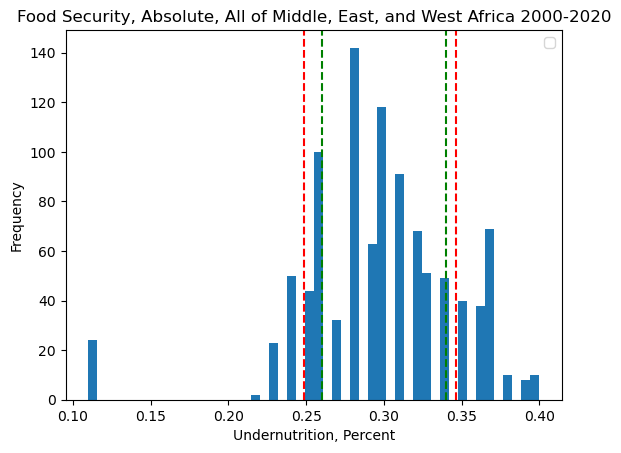

In [ ]:
#
fs = undernourishment_timeseries[0,:,:].flatten()
fs_std_value = np.nanstd(fs)
fs_mean_value = np.nanmean(fs)
plt.hist(fs,bins=50)
plt.axvline(x=fs_mean_value+1*fs_std_value, color='red', linestyle='--')#, label=f'+1 Sigma')
plt.axvline(x=fs_mean_value-1*fs_std_value, color='red', linestyle='--')#, label=f'-1 Sigma')
plt.axvline(x=np.nanquantile(fs,.2), color='green', linestyle='--')#, label=f'+1 Sigma')
plt.axvline(x=np.nanquantile(fs,0.8), color='green', linestyle='--')#, label=f'-1 Sigma')

plt.title("Food Security, Absolute, All of Middle, East, and West Africa 2000-2020")
plt.xlabel("Undernutrition, Percent")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
data_timeseries.shape

(10, 43, 24)

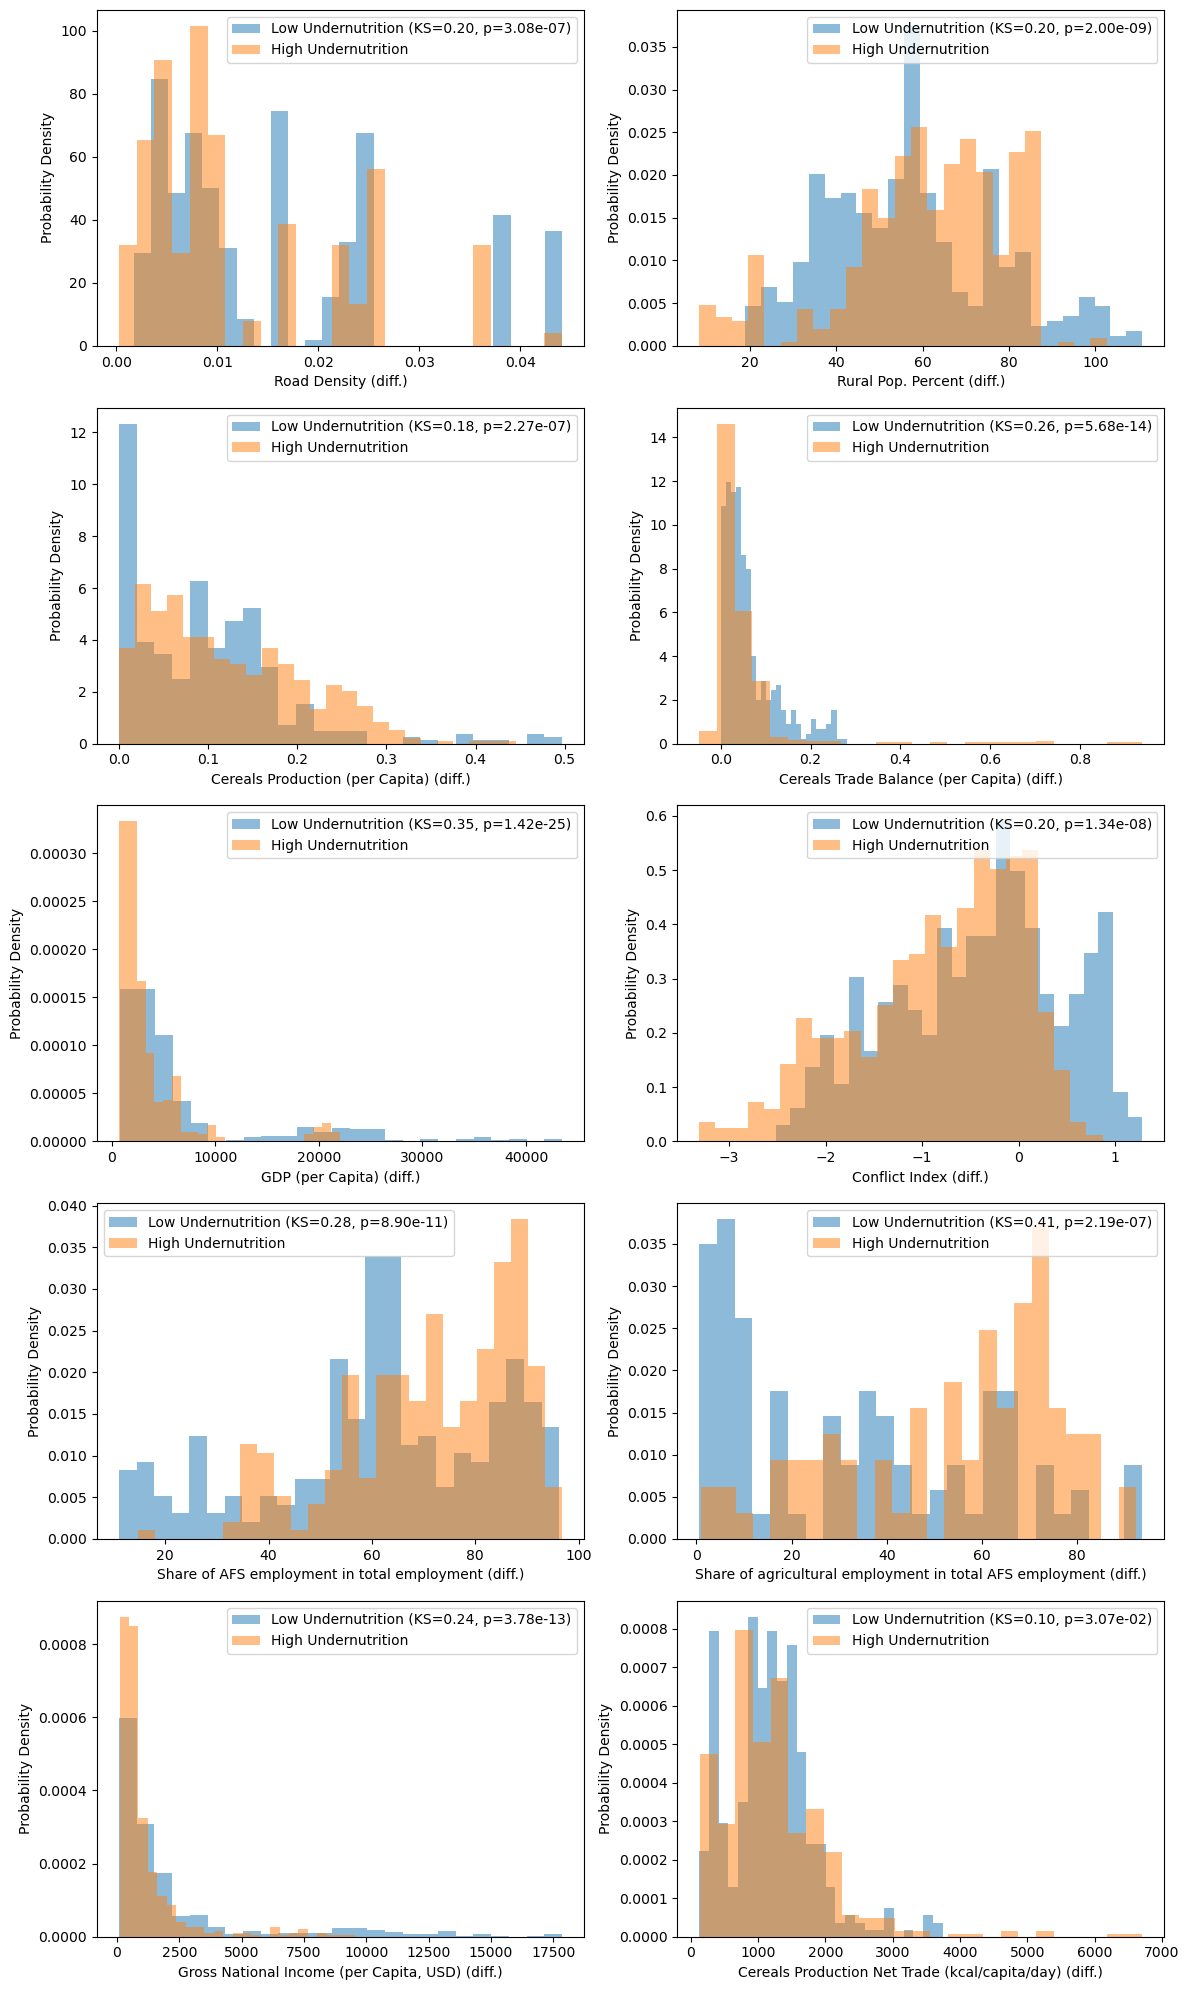

In [ ]:
from scipy.stats import ks_2samp

# Arrange the histograms for each variable in subplots.
num_vars = len(all_variables)
cols = 2
rows = (num_vars + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
axes = axes.flatten()

for idx, variable_name in enumerate(all_variables[0:]):
    ax = axes[idx]
    
    # Extract data for low and high undernutrition masks
    low_data = data_timeseries[idx, :, :].flatten()[fs < fs_mean_value]# - fs_std_value]
    high_data = data_timeseries[idx, :, :].flatten()[fs > fs_mean_value]# + fs_std_value]
    
    # Perform KS test
    ks_stat, ks_pvalue = ks_2samp(low_data[~np.isnan(low_data)], high_data[~np.isnan(high_data)])
    
    # Plot histogram for low undernutrition
    ax.hist(
        low_data,
        bins=25,
        density=True,
        alpha=0.5,
        range=(np.nanmin(low_data), np.nanmax(low_data)),
        label=f"Low Undernutrition (KS={ks_stat:.2f}, p={ks_pvalue:.2e})"
    )
    
    # Plot histogram for high undernutrition
    ax.hist(
        high_data,
        bins=25,
        density=True,
        alpha=0.5,
        range=(np.nanmin(high_data), np.nanmax(high_data)),
        label="High Undernutrition"
    )
    # Plot histogram for normal FS changes
    #normal_mask = (fs < fs_mean_value + fs_std_value) & (fs > fs_mean_value - fs_std_value)
    #x= explanatory_variable[idx, :, :].flatten()[normal_mask]
    #ax.hist(
    #    x,
    #    bins=25,
    #    density=True,
    #    alpha=0.5,
    #    range=(np.nanmin(x),np.nanmax(x)),
    #    label="Normal Undernutrition"
    #)
    
    ax.set_xlabel(variable_name + " (diff.)")
    ax.set_ylabel("Probability Density")
    ax.legend()

# Remove any unused axes (if the grid is larger than needed)
for ax in axes[num_vars:]:
    ax.remove()

plt.tight_layout()
plt.show()

In [ ]:
# Define thresholds for low, high, and normal undernutrition
low_threshold = fs_mean_value - fs_std_value
high_threshold = fs_mean_value + fs_std_value

# Extract variables 8 and 11
var8 = data_timeseries[1, :, :].flatten()
var11 = data_timeseries[10, :, :].flatten()

# Create a mask for each category
low_mask = fs < low_threshold
high_mask = fs > high_threshold
normal_mask = (fs >= low_threshold) & (fs <= high_threshold)

# Plot the scatter plot
plt.figure(figsize=(10, 6))

# Plot low undernutrition
plt.scatter(var8[low_mask], var11[low_mask], color='blue', label='Low Undernutrition', alpha=0.6)

# Plot high undernutrition
plt.scatter(var8[high_mask], var11[high_mask], color='red', label='High Undernutrition', alpha=0.6)

# Plot normal undernutrition
plt.scatter(var8[normal_mask], var11[normal_mask], color='green', label='Normal Undernutrition', alpha=0.6)

# Add labels and legend
plt.xlabel('Variable 8')
plt.ylabel('Variable 11')
plt.title('Scatter Plot of Variables 8 and 11 with Undernutrition Levels')
plt.legend()
plt.grid(True)
plt.show()

IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Reshape as before
reshaped_data = data_timeseries.reshape(data_timeseries.shape[0], -1).T
flat_fs = fs.flatten()

# Label encoding: 0 = low, 1 = normal, 2 = high
labels = np.full(flat_fs.shape, 1)
labels[flat_fs < low_threshold] = 0
labels[flat_fs > high_threshold] = 2

# Impute & scale
imputer = SimpleImputer(strategy='median')
data_imputed = imputer.fit_transform(reshaped_data)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

# PCA projection
pca = PCA(n_components=3)
proj = pca.fit_transform(data_scaled)


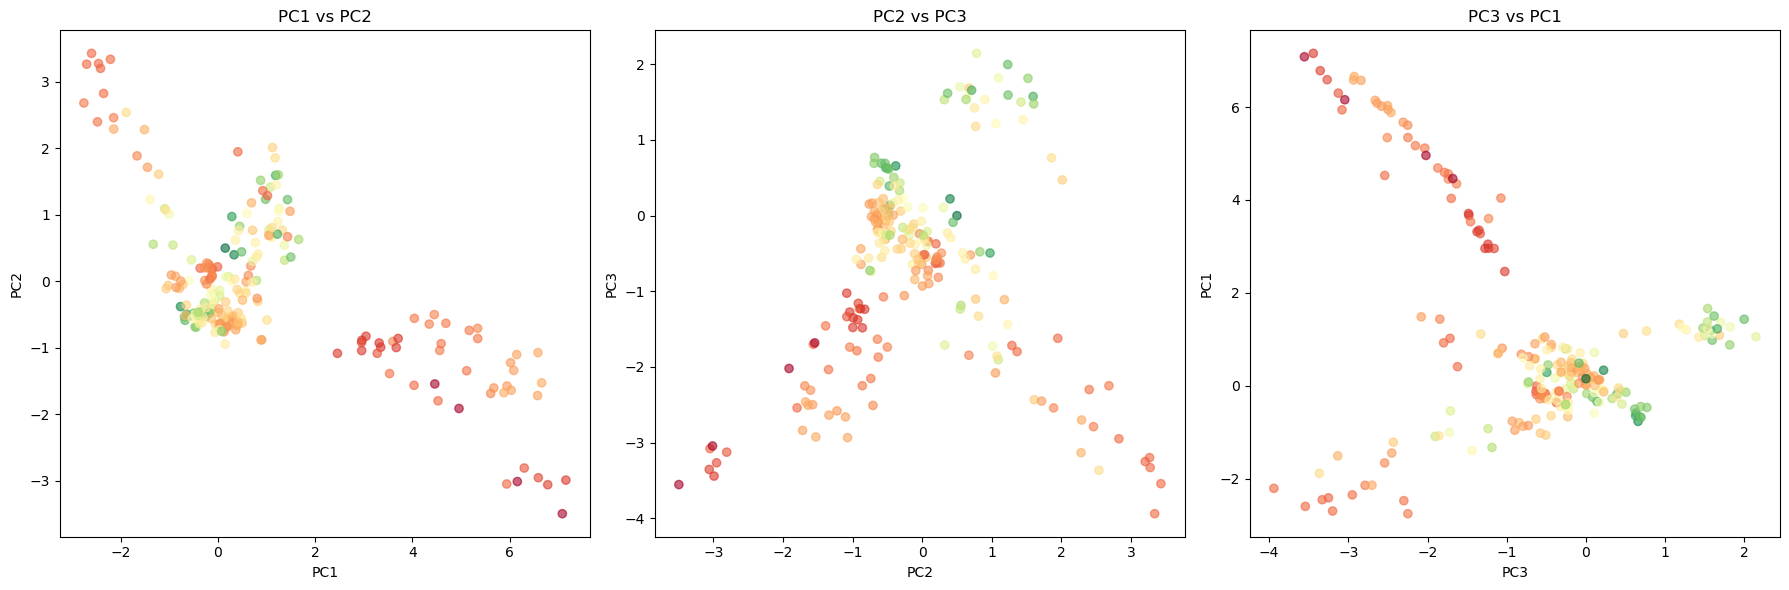

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fs_quantiled = fs.copy()
fs_quantiled[~np.hstack([(np.ones(undernourishment_timeseries.shape[2])*np.nansum((undernourishment_timeseries[0,i,:]<low_threshold))>0) & (np.ones(undernourishment_timeseries.shape[2])*np.nansum((undernourishment_timeseries[0,i,:]<low_threshold))<42) for i in range(undernourishment_timeseries.shape[1])])] = np.nan

# PC1 vs PC2
axes[0].scatter(proj[:, 0], proj[:, 1], c=fs_quantiled, cmap='RdYlGn', alpha=0.6)
axes[0].set_title("PC1 vs PC2")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# PC2 vs PC3
axes[1].scatter(proj[:, 1], proj[:, 2], c=fs_quantiled, cmap='RdYlGn', alpha=0.6)
axes[1].set_title("PC2 vs PC3")
axes[1].set_xlabel("PC2")
axes[1].set_ylabel("PC3")

# PC3 vs PC1
axes[2].scatter(proj[:, 2], proj[:, 0], c=fs_quantiled, cmap='RdYlGn', alpha=0.6)
axes[2].set_title("PC3 vs PC1")
axes[2].set_xlabel("PC3")
axes[2].set_ylabel("PC1")

plt.tight_layout()
plt.show()

In [ ]:
# Define thresholds for low, normal, and high food insecurity
low_threshold = fs_mean_value - fs_std_value
high_threshold = fs_mean_value + fs_std_value

# Initialize a dictionary to store the results
country_ratios = {}

# Iterate over each country (axis 1 in fs)
for i, country in enumerate(areas):
    # Extract the food security data for the country
    country_fs = undernourishment_timeseries[0,i, :]

    # Count the number of years in each category
    total_years = np.sum(~np.isnan(country_fs))  # Exclude NaN values
    low_years = np.sum(country_fs < low_threshold)
    high_years = np.sum(country_fs > high_threshold)
    normal_years = total_years - low_years - high_years

    # Calculate the ratios
    low_ratio = low_years / total_years if total_years > 0 else 0
    normal_ratio = normal_years / total_years if total_years > 0 else 0
    high_ratio = high_years / total_years if total_years > 0 else 0
    
    # Store the results in the dictionary
    country_ratios[country] = {
        "Low Ratio": low_ratio,
        "Normal Ratio": normal_ratio,
        "High Ratio": high_ratio
    }

# Display the results
for country, ratios in country_ratios.items():
    print(f"{country}: {ratios}")

Angola: {'Low Ratio': 0.0, 'Normal Ratio': 0.6363636363636364, 'High Ratio': 0.36363636363636365}
Benin: {'Low Ratio': 0.0, 'Normal Ratio': 1.0, 'High Ratio': 0.0}
Burkina Faso: {'Low Ratio': 0.0, 'Normal Ratio': 1.0, 'High Ratio': 0.0}
Burundi: {'Low Ratio': 0, 'Normal Ratio': 0, 'High Ratio': 0}
Cabo Verde: {'Low Ratio': 0.0, 'Normal Ratio': 1.0, 'High Ratio': 0.0}
Cameroon: {'Low Ratio': 0.6363636363636364, 'Normal Ratio': 0.36363636363636365, 'High Ratio': 0.0}
Central African Republic: {'Low Ratio': 0.0, 'Normal Ratio': 0.7272727272727273, 'High Ratio': 0.2727272727272727}
Chad: {'Low Ratio': 0.0, 'Normal Ratio': 0.8181818181818182, 'High Ratio': 0.18181818181818182}
Comoros: {'Low Ratio': 0.0, 'Normal Ratio': 1.0, 'High Ratio': 0.0}
Congo: {'Low Ratio': 0.0, 'Normal Ratio': 0.7727272727272727, 'High Ratio': 0.22727272727272727}
Côte d'Ivoire: {'Low Ratio': 0.045454545454545456, 'Normal Ratio': 0.9545454545454546, 'High Ratio': 0.0}
Democratic Republic of the Congo: {'Low Ratio': 

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def symmetrical_colormap(cmap_settings, new_name = None ):
    ''' This function take a colormap and create a new one, as the concatenation of itself by a symmetrical fold.
    '''
    # get the colormap
    cmap = plt.cm.get_cmap(*cmap_settings)
    if not new_name:
        new_name = "sym_"+cmap_settings[0]  # ex: 'sym_Blues'
    
    # this defined the roughness of the colormap, 128 fine
    n= 128 
    
    # get the list of color from colormap
    colors_r = cmap(np.linspace(0, 1, n))    # take the standard colormap # 'right-part'
    colors_l = colors_r[::-1]                # take the first list of color and flip the order # "left-part"

    # combine them and build a new colormap
    colors = np.vstack((colors_l, colors_r))
    mymap = mcolors.LinearSegmentedColormap.from_list(new_name, colors)

    return mymap
# --- Quick test -------------------------
cmap_settings = ('Blues', None)  # provide int instead of None to "discretize/bin" the colormap
mymap = symmetrical_colormap(cmap_settings= cmap_settings, new_name =None )


import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming `areas` is a list or array of unique area names
areas = np.unique(area_labels)  # Ensure unique areas
num_areas = len(areas)

# Create a colormap with as many colors as there are areas
cmap = plt.cm.get_cmap('tab20', num_areas)  # Use 'tab20' colormap for distinct colors

# Create a dictionary mapping each area to a color
area_colors = {area: cmap(i) for i, area in enumerate(areas)}


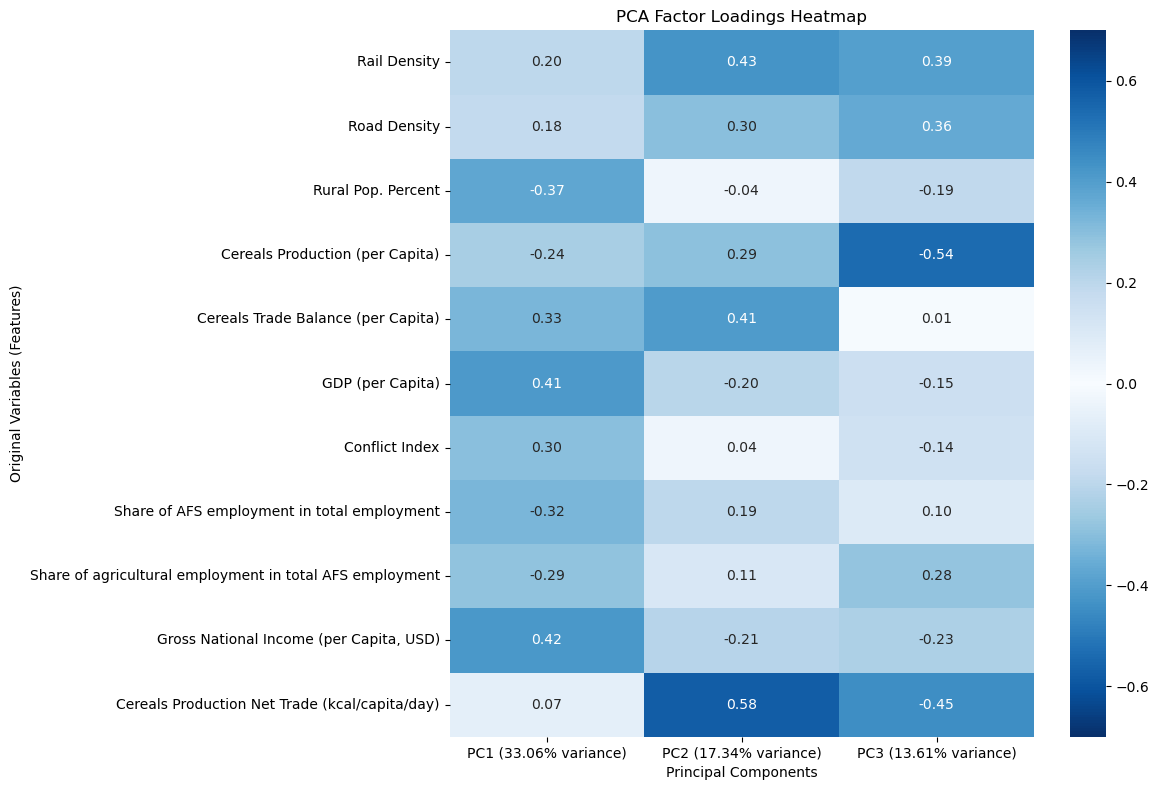

In [ ]:
import seaborn as sns

# Calculate the percentage of variance explained by each PC
explained_variance = pca.explained_variance_ratio_ * 100

# Create a DataFrame for easy viewing
# Rows: Principal Components, Columns: Original Variables (Features)
# Transpose loadings so original features are rows and PCs are columns
loadings_df = pd.DataFrame(
    loadings.T, 
    columns=[f'PC{i+1} ({explained_variance[i]:.2f}% variance)' for i in range(len(explained_variance))], 
    index=feature_names
)

# Visualize the loadings with a heatmap

plt.figure(figsize=(12, 8))  # Adjust size as needed
sns.heatmap(loadings_df, cmap=mymap, vmin=-0.7, vmax=0.7, annot=True, fmt='.2f')
plt.title('PCA Factor Loadings Heatmap')
plt.xlabel('Principal Components')
plt.ylabel('Original Variables (Features)')
plt.tight_layout()  # Adjust layout
plt.show()

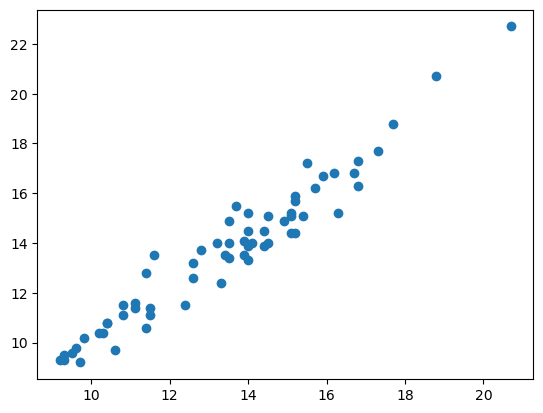

In [ ]:
plt.scatter(undernourishment_timeseries[0, 1:5, 1:],undernourishment_timeseries[0, 1:5, 0:-1])

### 2. Changes

In [ ]:
undernourishment_timeseries.shape 

(1, 43, 24)

In [ ]:
norm_fs= ((undernourishment_timeseries[0,:,:]-np.nanmean(undernourishment_timeseries[0,:,:],axis=0))/np.nanstd(undernourishment_timeseries[0,:,:],axis=0))

Text(0, 0.5, 'Frequency')

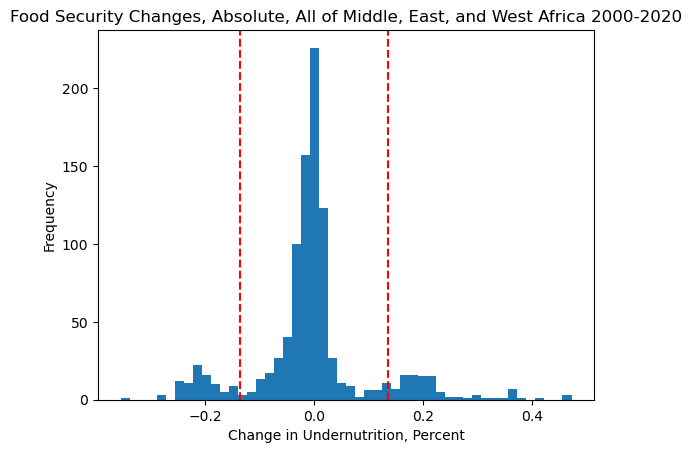

In [ ]:
#find histogram of percent differences
fs_changes = np.diff(norm_fs,axis=1).flatten() #food security change data,flatttened
plt.hist(fs_changes,bins=50,range=(np.nanquantile(fs_changes,.01),np.nanquantile(fs_changes,.99)))
fs_changes_std_value = np.nanstd(fs_changes)
fs_changes_mean_value = np.nanmean(fs_changes)
plt.axvline(x=fs_changes_mean_value+1*fs_changes_std_value, color='red', linestyle='--', label=f'Std: {fs_changes_std_value:.2f}')
plt.axvline(x=fs_changes_mean_value-1*fs_changes_std_value, color='red', linestyle='--', label=f'Std: {fs_changes_std_value:.2f}')
plt.title("Food Security Changes, Absolute, All of Middle, East, and West Africa 2000-2020")
plt.xlabel("Change in Undernutrition, Percent")
plt.ylabel("Frequency")

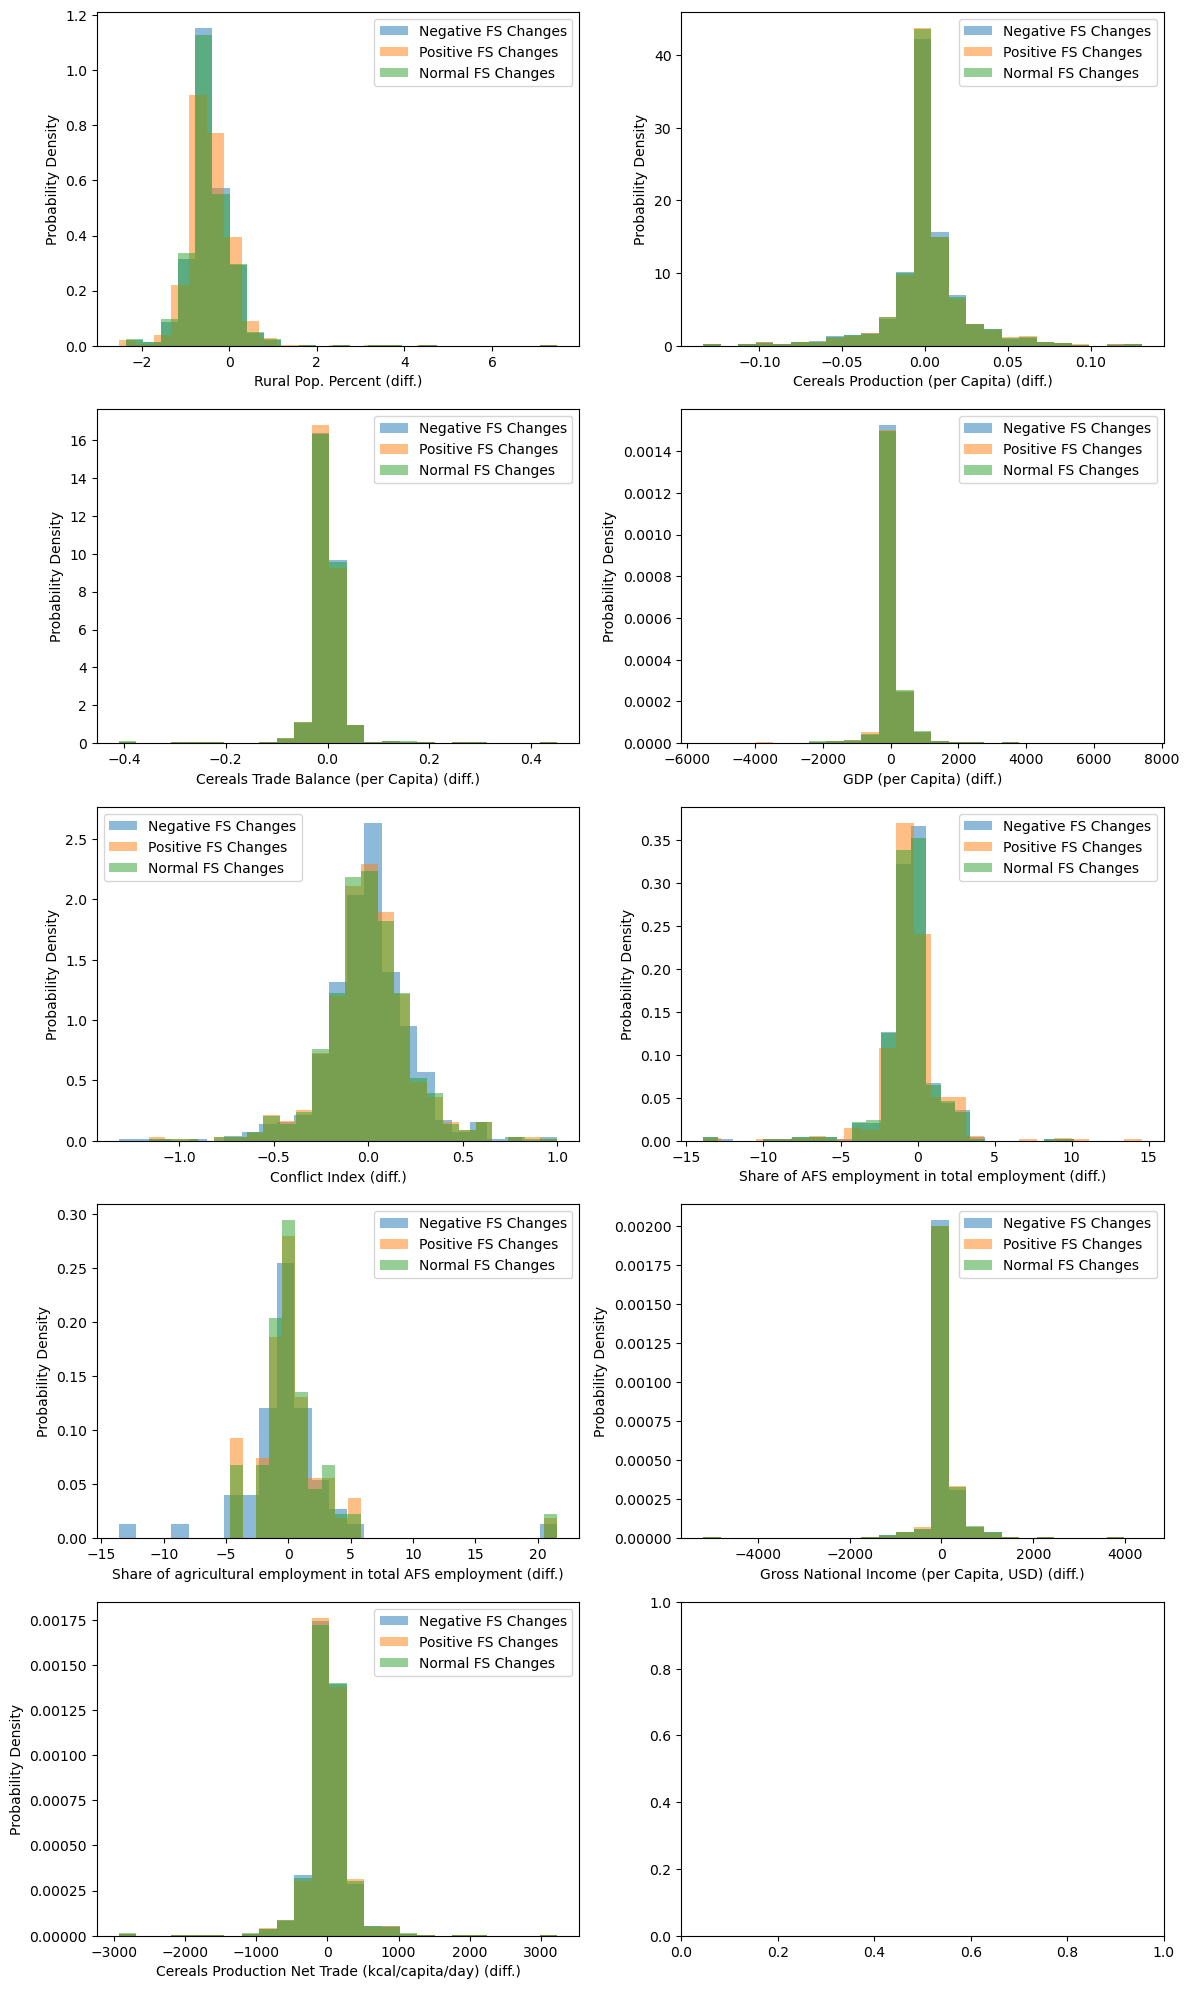

In [ ]:
explanatory_variable = np.diff(data_timeseries[:,:,:],axis=2)#/data_timeseries[1, :, :-1] * 100 #food security change data,flatttened

# Arrange the histograms for each variable in subplots.
num_vars = len(all_variables)
cols = 2
rows = (num_vars + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
axes = axes.flatten()


for idx, variable_name in enumerate(all_variables[1:]):
    ax = axes[idx]
    idx=idx+1
    # Plot histogram for negative FS changes
    x=explanatory_variable[idx, :, :].flatten()[fs_changes < fs_changes_mean_value + fs_changes_std_value]
    ax.hist(
        x,
        bins=25,
        density=True,
        alpha=0.5,
        range=(np.nanmin(x),np.nanmax(x)),
        label="Negative FS Changes"
    )
    
    # Plot histogram for positive FS changes
    x=explanatory_variable[idx, :, :].flatten()[fs_changes > fs_changes_mean_value - fs_changes_std_value]
    ax.hist(
        x,
        bins=25,
        density=True,
        alpha=0.5,
        range=(np.nanmin(x),np.nanmax(x)),
        label="Positive FS Changes"
    )
    
    # Plot histogram for normal FS changes
    normal_mask = (fs_changes < fs_changes_mean_value + fs_changes_std_value) & (fs_changes > fs_changes_mean_value - fs_changes_std_value)
    x= explanatory_variable[idx, :, :].flatten()[normal_mask]
    ax.hist(
        x,
        bins=25,
        density=True,
        alpha=0.5,
        range=(np.nanmin(x),np.nanmax(x)),
        label="Normal FS Changes"
    )
    
    ax.set_xlabel(variable_name + " (diff.)")
    ax.set_ylabel("Probability Density")
    ax.legend()

# Remove any unused axes (if the grid is larger than needed)
for ax in axes[num_vars:]:
    ax.remove()
plt.title("")
plt.tight_layout()
plt.show()


# Adding Seasonality to the Food Balance Sheet

#### 1. Beginning by the classic counterfactual -- one where stocks seems to be growing, one where domestic supply is still extremely low. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the two CSV files
df_old = pd.read_csv('../Data/1DSUM-National/FAOSTAT_FBS-Cereals-National-Africa_1961-2013.csv')
df_new = pd.read_csv('../Data/1DSUM-National/FAOSTAT_FBS-Cereals-National-Africa_2010-2022.csv')

# Ensure 'Year' column is numeric
df_old['Year'] = pd.to_numeric(df_old['Year'], errors='coerce')
df_new['Year'] = pd.to_numeric(df_new['Year'], errors='coerce')

# Filter the old dataframe to include only years up to 2009
df_old_filtered = df_old[df_old['Year'] <= 2009]

# Combine the filtered old dataframe with the new dataframe
FBS_Cereals_Complete_National = pd.concat([df_old_filtered, df_new], ignore_index=True)

# Optional: sort by year and reset index
FBS_Cereals_Complete_National = FBS_Cereals_Complete_National.sort_values(by='Year').reset_index(drop=True)
FBS_Cereals_Complete_National['Element'].replace({"Import Quantity": "Import quantity", "Export Quantity": "Export quantity"}, inplace=True)
National_Populations=pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-population+ruralurban_1950-2023.csv")

<AxesSubplot: title={'center': 'Senegal Food Supply (kcal/capita/day)'}, xlabel='Year', ylabel='Food Supply (kcal/capita/day)'>

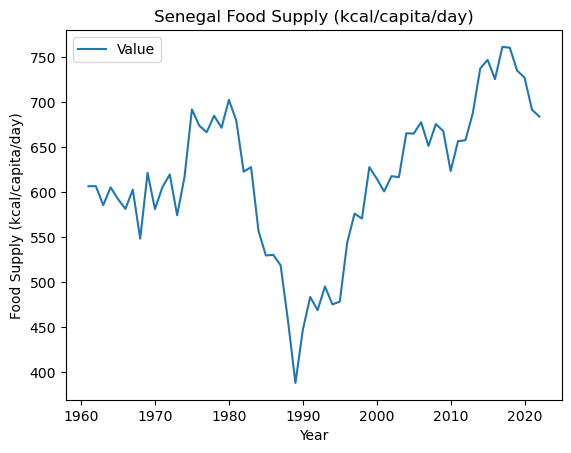

In [ ]:
FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Element =='Food supply (kcal/capita/day)') & (FBS_Cereals_Complete_National.Area == 'Angola')].groupby('Year').sum().reset_index().plot(x='Year',y='Value',title="Senegal Food Supply (kcal/capita/day)",ylabel="Food Supply (kcal/capita/day)",xlabel="Year")

Text(0, 0.5, 'alpha')

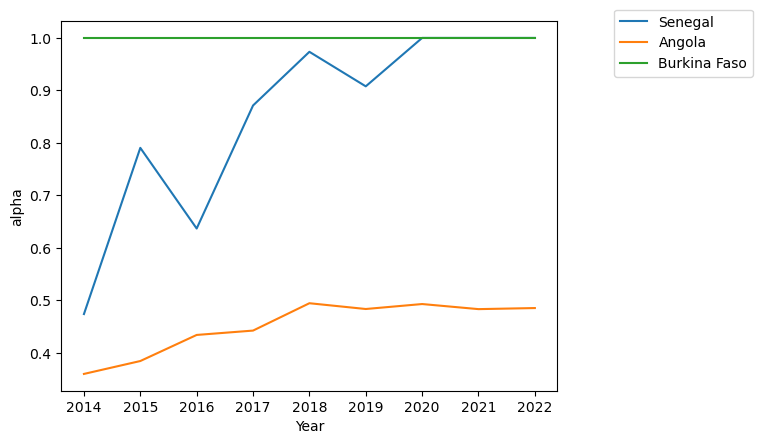

In [ ]:
cereal_caloric_density = 2609*1000 # kcal/ton 
caloric_requirment = 1240*365 # 1200 kcal/year

national_years = FBS_Cereals_Complete_National.Year.unique()
national_years = national_years[-30:]
target_nations =  ['Senegal','Angola','Burkina Faso']
national_stocks = np.zeros((len(target_nations),len(national_years)))+0.01
national_percapita_stocks = np.zeros((len(target_nations),len(national_years)))+0.01

national_alpha = np.ones((len(target_nations),len(national_years)))
for r,region in enumerate(target_nations):
    #stocks[r,0] = regional_stocks_df[(regional_stocks_df.region == region) & (regional_stocks_df.Year == years[0])].stock.values*1000 # tons
    seed = 0.03
    loss = 0.04
    cereal_caloric_density = 2609*1000 # kcal/ton 
    caloric_requirment = 1240*365 # 1200 kcal/year
    #stocks[r,0] = regional_cereals_stocks_obs[region][30]*1000
    for i in np.arange(1,len(national_years)):
        processing = 0# regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Processing
        economic_use = 0#regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Other + regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Feed
        Pop = 1000*National_Populations[(National_Populations.Year == national_years[i]) & (National_Populations.Area == region ) & (National_Populations.Element == 'Total Population - Both sexes')].Value.values[0] #[people]
        residuals = 0#regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Residuals
        Y = 1000*FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == national_years[i])&(FBS_Cereals_Complete_National.Element =='Production') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value
        try:
            trade_balance = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == national_years[i])&(FBS_Cereals_Complete_National.Element =='Import quantity') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value - FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == national_years[i])&(FBS_Cereals_Complete_National.Element =='Export quantity') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value
            trade_balance = 0*trade_balance*1000 # tons
        except:
            trade_balance =0 
            print(region)
        food = Pop*caloric_requirment/cereal_caloric_density # in tons
        total_supply = Y+trade_balance
        if national_stocks[r,i-1] + trade_balance + (Y*(1-seed-loss) - national_alpha[r,i]*food*(1+processing) - total_supply*economic_use) > 0:
            national_alpha[r,i] = 1
        else:
            national_alpha[r,i] = (national_stocks[r,i-1] + trade_balance + Y*(1-seed-loss) - total_supply*economic_use)/(food*(1+processing))
            national_alpha[r,i] = national_alpha[r,i].clip(0,1)
        dstock = trade_balance + Y*(1-seed-loss) - national_alpha[r,i]*food - total_supply*(economic_use+processing+residuals)
        national_stocks[r,i] = national_stocks[r,i-1] + dstock - national_stocks[r,i-1]*1 #*stock_use_ratio #- 0.1*stocks[r,i-1] # 10% of the stocks are lost each year
        #national_percapita_stocks[r,i] = national_stocks[r,i]/Pop



colors = plt.cm.tab20c.colors  # 20 colors, plus an additional one from the "tab20c" colormap
# Make sure that there are 21 colors by repeating the last one if needed
colors = list(colors) + [colors[-1]]
fig = plt.figure()
ax = plt.subplot(111)

for r,region in enumerate(target_nations):
    if national_alpha[r,:].mean()<1.1: #(region == "Western Africa"):
        plt.plot(national_years[-9:],national_alpha[r,-9:],label=region)#color=colors[r])
        ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_xlabel('Year')
ax.set_ylabel('alpha')


#### 2. Add monthly resolution

In [ ]:
national_crop_calendar = pd.read_csv(r"..\Data/1DSUM-National/crop_calendar_gaul0.csv",delimiter=';')
# 1. Calculate months from dekads
def dekad_to_month(dekad):
    # Each month has 3 dekads, so we divide by 3 and round up
    return min(12, max(1, (dekad - 1) // 3 + 1))

# Add harvest_start_month and harvest_end_month columns
national_crop_calendar['harvest_start_month'] = national_crop_calendar['eos_s'].apply(dekad_to_month)
national_crop_calendar['harvest_end_month'] = national_crop_calendar['eos_e'].apply(dekad_to_month)

# 2. Create monthly harvest proportions
def create_harvest_array(start_month, end_month):
    # Create an array of zeros
    arr = np.zeros(12)
    
    # Handle wrap-around case (e.g., if harvest starts in November and ends in February)
    if start_month <= end_month:
        # Set to 1 for each month in the harvest period (inclusive of end_month)
        for month in range(start_month, end_month + 1):
            arr[month - 1] = 1
    else:
        # Set to 1 for months from start_month to December
        for month in range(start_month, 13):
            arr[month - 1] = 1
        # Set to 1 for months from January to end_month
        for month in range(1, end_month + 1):
            arr[month - 1] = 1
    
    # 3. Normalize the array
    if arr.sum() > 0:  # Avoid division by zero
        arr = arr / arr.sum()
    
    return arr

# Apply the function to each row
national_crop_calendar['monthly_harvest_proportions'] = national_crop_calendar.apply(
    lambda row: create_harvest_array(row['harvest_start_month'], row['harvest_end_month']), 
    axis=1
)

,Unnamed: 0,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
0,0,C,M,20151001,2015,10,201510,24,AGO,Angola,...,1118862.0,False,0.0,False,0.000,609588.520,609588.520,0,False,True
1,1,C,M,20150301,2015,3,201503,24,AGO,Angola,...,51.0,False,0.0,False,0.000,336.820,336.820,0,False,True
2,2,C,M,20150801,2015,8,201508,24,AGO,Angola,...,91.0,False,0.0,False,0.000,142.570,142.570,0,False,True
3,3,C,M,20150801,2015,8,201508,24,AGO,Angola,...,440.0,False,0.0,False,0.000,204.460,204.460,0,False,True
4,4,C,M,20151001,2015,10,201510,24,AGO,Angola,...,1046.0,False,0.0,False,2754.230,2504.720,2754.230,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5130,43,C,M,20240101,2024,1,202401,854,BFA,Burkina Faso,...,467.0,False,0.0,False,569.669,NaN,569.669,0,False,True
5131,44,C,M,20240101,2024,1,202401,854,BFA,Burkina Faso,...,130000.0,False,0.0,False,4453.774,NaN,4453.774,0,False,True
5132,45,C,M,20240201,2024,2,202402,854,BFA,Burkina Faso,...,4777.0,False,0.0,False,3290.926,NaN,3290.926,0,False,True
5133,46,C,M,20240201,2024,2,202402,854,BFA,Burkina Faso,...,190000.0,False,0.0,False,8587.996,NaN,8587.996,0,False,True


In [ ]:
Angola_Monthly_Trade = pd.read_csv(r"..\Data\trade\Angola_Monthly_Trade_Rice-Maize-Wheat-Sorghum-Barley-Oats-Millet-Rye_2000-2025")
Senegal_Monthly_Trade = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\trade\Senegal_Monthly_Trade_Rice-Maize-Wheat-Sorghum-Barley-Oats-Millet-Rye_2000-2025")
BurkinaFaso_Monthly_Trade = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\trade\BurkinaFaso_Monthly_Trade_Rice-Maize-Wheat-Sorghum-Barley-Oats-Millet-Rye_2000-2025")
#Senegal_Monthly_Trade.append)
Senegal_Monthly_Trade = pd.concat([Senegal_Monthly_Trade,BurkinaFaso_Monthly_Trade])
np.sort(Senegal_Monthly_Trade[Senegal_Monthly_Trade.reporterDesc=="Senegal"].refYear.unique())

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2022], dtype=int64)

In [ ]:
region = "Burkina Faso"
year = 2021
for month in np.arange(12):
    try:
        if year in Senegal_Monthly_Trade[Senegal_Monthly_Trade.reporterDesc==region].refYear.unique():
            Imports_month =Senegal_Monthly_Trade[(Senegal_Monthly_Trade.flowDesc == "Import")&(Senegal_Monthly_Trade.partnerDesc == "World")&(Senegal_Monthly_Trade.refYear == year) & (Senegal_Monthly_Trade.refMonth == month + 1) & (Senegal_Monthly_Trade.reporterDesc == region)].netWgt.sum()
            Exports_month = Senegal_Monthly_Trade[(Senegal_Monthly_Trade.flowDesc == "Export")&(Senegal_Monthly_Trade.partnerDesc == "World")&(Senegal_Monthly_Trade.refYear == year) & (Senegal_Monthly_Trade.refMonth == month + 1) & (Senegal_Monthly_Trade.reporterDesc == region)].netWgt.sum()
            Imports_year = Senegal_Monthly_Trade[(Senegal_Monthly_Trade.flowDesc == "Import")&(Senegal_Monthly_Trade.partnerDesc == "World")&(Senegal_Monthly_Trade.refYear == year) & (Senegal_Monthly_Trade.reporterDesc == region)].netWgt.sum()
            Exports_year = Senegal_Monthly_Trade[(Senegal_Monthly_Trade.flowDesc == "Export")&(Senegal_Monthly_Trade.partnerDesc == "World")&(Senegal_Monthly_Trade.refYear == year) & (Senegal_Monthly_Trade.reporterDesc == region)].netWgt.sum()
            trade_proportion = (Imports_month - Exports_month)/ (Imports_year-Exports_year)    
        else:
            trade_proprtion = 1/12
        trade_balance = trade_proportion*(FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year)&(FBS_Cereals_Complete_National.Element =='Import quantity') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value - FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year)&(FBS_Cereals_Complete_National.Element =='Export quantity') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value)
        trade_balance = trade_balance*1000 # tons
    except:
        trade_balance =0 
    print(Imports_month/Imports_year)

0.0630936698658099
0.08626268679374006
0.07563269009045574
0.06570588569169972
0.05560320795362612
0.08399677988133433
0.07989837120076118
0.0665900148754132
0.06049004658692921
0.10497673988116733
0.1155733531804026
0.1421765539986606


In [ ]:

cereal_caloric_density = 2609*1000 # kcal/ton 
caloric_requirment = 1240*365/12 # 1200 kcal/month
experiments = ["NoTrade","ConstTrade","VariedTrade"]
seasonal_results = {experiment:{} for experiment in experiments}
#
national_years = FBS_Cereals_Complete_National.Year.unique()
national_years = national_years[-30:]
target_nations =  ['Senegal','Burkina Faso']
for experiment in experiments:    
    national_stocks = np.zeros((len(target_nations),len(national_years)*12))+0.01
    national_percapita_stocks = np.zeros((len(target_nations),len(national_years)*12))+0.01
    national_alpha = np.ones((len(target_nations),len(national_years)*12))
    print("Running Experiment:",experiment)  
    for r,region in enumerate(target_nations):
        #stocks[r,0] = regional_stocks_df[(regional_stocks_df.region == region) & (regional_stocks_df.Year == years[0])].stock.values*1000 # tons
        seed = 0.03
        loss = 0.04
        for i,year in enumerate(national_years):
            print(i)
            for month in np.arange(12):
                processing = 0
                economic_use = 0
                residuals = 0
                Pop = 1000*(National_Populations[(National_Populations.Year == year) & (National_Populations.Area == region ) & (National_Populations.Element == 'Total Population - Both sexes')].Value.values[0]   +   (month/12)*(National_Populations[(National_Populations.Year == year+1) & (National_Populations.Area == region ) & (National_Populations.Element == 'Total Population - Both sexes')].Value.values[0]   -   National_Populations[(National_Populations.Year == year) & (National_Populations.Area == region ) & (National_Populations.Element == 'Total Population - Both sexes')].Value.values[0]))
                Y = 0 
                for cereal_item in FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year)&(FBS_Cereals_Complete_National.Element =='Production') & (FBS_Cereals_Complete_National.Area == region)].Item.unique():
                    crop_short = cereal_item.split(' ')[0]
                    try:
                        harvest_percentage = national_crop_calendar[(national_crop_calendar.name0_shr == region)&(national_crop_calendar.crop_name == crop_short)].monthly_harvest_proportions.iloc[0][month]
                    except:
                        harvest_percentage = 1/12
                    Y +=  1000*harvest_percentage*FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year)&(FBS_Cereals_Complete_National.Element =='Production') & (FBS_Cereals_Complete_National.Area == region)& (FBS_Cereals_Complete_National.Item == cereal_item)].iloc[0].Value
                    #economic_use += (FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Area == region) & (FBS_Cereals_Complete_National.Year == year) & (FBS_Cereals_Complete_National.Element =='Feed') & (FBS_Cereals_Complete_National.Item == cereal_item)].iloc[0].Value  +  FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Area == region) & (FBS_Cereals_Complete_National.Year == year) & (FBS_Cereals_Complete_National.Element =='Other uses (non-food)') & (FBS_Cereals_Complete_National.Item == cereal_item)].iloc[0].Value)  
                try:
                    if year in Senegal_Monthly_Trade[Senegal_Monthly_Trade.reporterDesc==region].refYear.unique():
                        Imports_month =Senegal_Monthly_Trade[(Senegal_Monthly_Trade.flowDesc == "Import")&(Senegal_Monthly_Trade.partnerDesc == "World")&(Senegal_Monthly_Trade.refYear == year) & (Senegal_Monthly_Trade.refMonth == month + 1) & (Senegal_Monthly_Trade.reporterDesc == region)].netWgt.sum()
                        Exports_month = Senegal_Monthly_Trade[(Senegal_Monthly_Trade.flowDesc == "Export")&(Senegal_Monthly_Trade.partnerDesc == "World")&(Senegal_Monthly_Trade.refYear == year) & (Senegal_Monthly_Trade.refMonth == month + 1) & (Senegal_Monthly_Trade.reporterDesc == region)].netWgt.sum()
                        Imports_year = Senegal_Monthly_Trade[(Senegal_Monthly_Trade.flowDesc == "Import")&(Senegal_Monthly_Trade.partnerDesc == "World")&(Senegal_Monthly_Trade.refYear == year) & (Senegal_Monthly_Trade.reporterDesc == region)].netWgt.sum()
                        Exports_year = Senegal_Monthly_Trade[(Senegal_Monthly_Trade.flowDesc == "Export")&(Senegal_Monthly_Trade.partnerDesc == "World")&(Senegal_Monthly_Trade.refYear == year) & (Senegal_Monthly_Trade.reporterDesc == region)].netWgt.sum()
                        trade_proportion = (Imports_month - Exports_month)/ (Imports_year-Exports_year)    
                    else:
                        trade_proprtion = 1/12
                    if experiment == "ConstTrade":
                        trade_proportion = 1/12
                    if experiment == "NoTrade":
                        trade_proportion = 0
                    trade_balance = trade_proportion*(FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year)&(FBS_Cereals_Complete_National.Element =='Import quantity') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value - FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year)&(FBS_Cereals_Complete_National.Element =='Export quantity') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value)
                    trade_balance = trade_balance*1000 # tons
                except:
                    trade_balance =0 
                    
                food = Pop*caloric_requirment/cereal_caloric_density # in tons
                total_supply = Y+trade_balance
                if national_stocks[r,12*i+month-1] + trade_balance + (Y*(1-seed-loss) - national_alpha[r,12*i+month]*food*(1+processing) - total_supply*economic_use) > 0:
                    national_alpha[r,12*i+month] = 1
                else:
                    national_alpha[r,12*i+month] = (national_stocks[r,12*i+month-1] + trade_balance + Y*(1-seed-loss) - total_supply*economic_use)/(food*(1+processing))
                    national_alpha[r,12*i+month] = national_alpha[r,12*i+month].clip(0,1)
                dstock = trade_balance + Y*(1-seed-loss) - national_alpha[r,12*i+month]*food - total_supply*(economic_use+processing+residuals)
                national_stocks[r,12*i+month] = national_stocks[r,12*i+month-1] + dstock - national_stocks[r,12*i+month-1]*(0.34) #*stock_use_ratio #- 0.1*stocks[r,i-1] # 10% of the stocks are lost each year
                #if national_stocks[r,12*i+month]<0:
                    #print(year)
                    #print(month)
                    #print("Negative Stocks")
                #national_percapita_stocks[r,i] = national_stocks[r,i]/Pop
        seasonal_results[experiment]["NationalStocks"]=national_stocks
        seasonal_results[experiment]["NationalAlpha"]=national_alpha





Running Experiment: NoTrade
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Running Experiment: ConstTrade
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Running Experiment: VariedTrade
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [ ]:
target_nations =  ['Senegal','Burkina Faso']

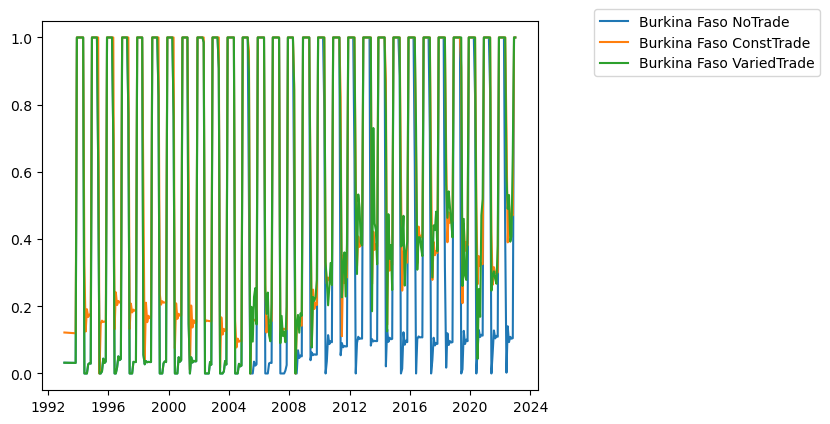

In [ ]:
colors = plt.cm.tab20c.colors  # 20 colors, plus an additional one from the "tab20c" colormap
# Make sure that there are 21 colors by repeating the last one if needed
colors = list(colors) + [colors[-1]]
fig = plt.figure()
ax = plt.subplot(111)
monthly_time =  pd.date_range(start=str(national_years[0]), end=str(national_years[-1]+1),freq="M")
for experiment in experiments:
    for r,region in enumerate(target_nations):
        if region == "Burkina Faso":
         if seasonal_results[experiment]["NationalAlpha"][r,:].mean()<1.1: #(region == "Western Africa"):
            plt.plot(monthly_time,seasonal_results[experiment]["NationalAlpha"][r,:],label=region + " " + experiment)
            ax.legend(bbox_to_anchor=(1.1, 1.05))


NameError: name 'national_years' is not defined

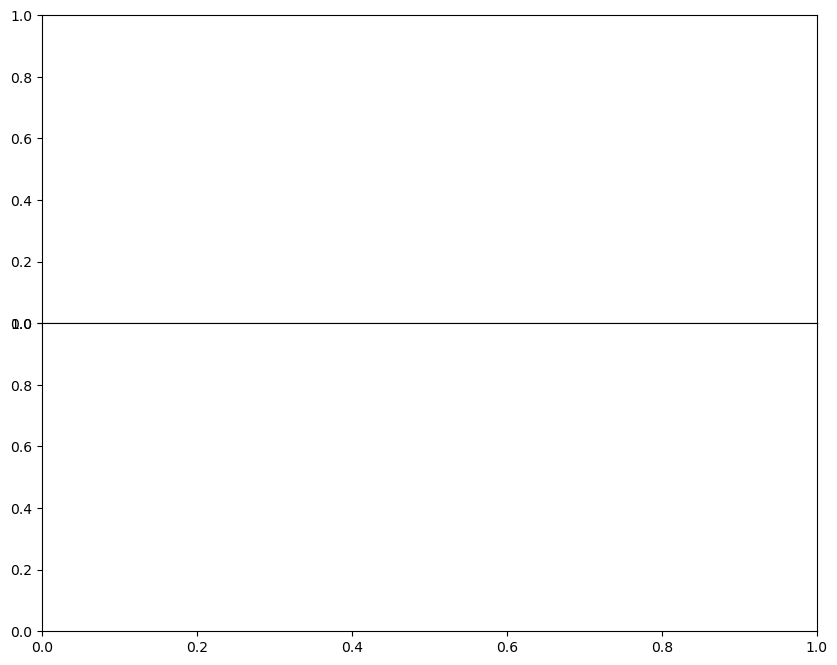

In [ ]:
colors = plt.cm.tab20c.colors  # 20 colors, plus an additional one from the "tab20c" colormap
# Make sure that there are 21 colors by repeating the last one if needed
colors = list(colors) + [colors[-1]]

# Create a figure with two subplots, stacked vertically, sharing the x-axis, and no hspace
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 8), gridspec_kw={'hspace': 0})

monthly_time = pd.date_range(start=str(national_years[0]), end=str(national_years[-1]+1), freq="M")

# Plot for Senegal
region_senegal = target_nations[0]
axes[0].plot(monthly_time[-96:], national_alpha_varied_trade[0, -96:], label=region_senegal, color=colors[0])
axes[0].legend(loc='upper right')
axes[0].set_ylabel('alpha')
axes[0].set_title('Alpha Over Time') # Or a more general title if preferred

# Plot for Angola
region_angola = target_nations[1]
axes[1].plot(monthly_time[-96:], national_alpha_varied_trade[1, -96:], label=region_angola, color=colors[1])
axes[1].legend(loc='upper right')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('alpha')

# Adjust layout to prevent overlapping titles/labels if necessary
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust rect to make space for a potential figure-level legend or title
plt.show()

In [ ]:
test.reference_label.unique()

array(['Jan-May', 'Sep-Dec', 'Jun-Aug'], dtype=object)

In [ ]:
National_Food_Security_Indicators.Item.unique()

array(['Gross domestic product per capita, PPP, (constant 2017 international $)',
       'Prevalence of undernourishment (percent) (3-year average)',
       'Political stability and absence of violence/terrorism (index)',
       'Coefficient of variation of habitual caloric consumption distribution (real number)',
       'Rail lines density (total route in km per 100 square km of land area)'],
      dtype=object)

Text(0.5, 1.0, 'Senegal Food Security Alpha Estimate')

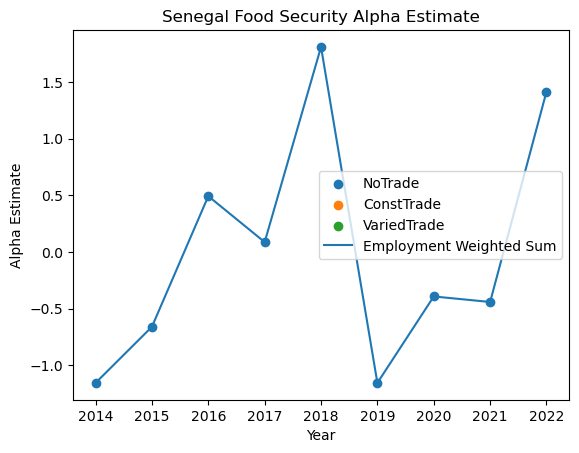

In [ ]:
all_alphas = np.zeros(len(national_years))
for experiment in experiments:
    national_alpha_exp = seasonal_results[experiment]["NationalAlpha"]
    r = 1 #r=0 for senegal
    alpha_estimate = np.array([np.sum((1-national_alpha_exp[r ,:][i*12:i*12+4])**(1)) for i in range(0,round(len(national_alpha_exp[r,:])/12))])
    if experiment == "NoTrade":
        all_alphas += (0.98)*alpha_estimate
        #all_alphas += (.34*.68)*alpha_estimate
    if experiment == "ConstTrade":
        all_alphas +=0*alpha_estimate
        #all_alphas +=(1-0.34)*alpha_estimate
    if experiment == "VariedTrade":
        all_alphas +=0*alpha_estimate
        #all_alphas += (.34*0.34)*alpha_estimate
    plt.scatter(national_years[-9:],((alpha_estimate[-9:]-np.mean(alpha_estimate[-9:]))/np.std(alpha_estimate[-9:])  ),label=experiment) #alpha_estimate[-9:],label=experiment)#1*np.convolve(alpha_estimate,np.ones(3),'same')/3)
plt.plot(national_years[-9:], ((all_alphas[-9:]-np.mean(all_alphas[-9:]))/np.std(all_alphas[-9:]))[:] ,label="Employment Weighted Sum")#1*np.convolve(alpha_estimate,np.ones(3),'same')/3)
plt.ylabel("Alpha Estimate")
plt.legend()
plt.xlabel("Year")
plt.title("Senegal Food Security Alpha Estimate")

In [ ]:
test = pd.read_excel(r"C:\Users\danie\Downloads\cadre_harmonise_caf_ipc.xlsx")
season = 'Jan-May'#'Jun-Aug'#
country = 'Burkina Faso'
phase1 = test[(test.adm0_name == country)&(test.chtype=="current")&(test.exercise_label==season)].groupby("exercise_year")["phase1"].sum() 
phase2 = test[(test.adm0_name == country)&(test.chtype=="current")&(test.exercise_label==season)].groupby("exercise_year")["phase2"].sum() 
phase3 = test[(test.adm0_name == country)&(test.chtype=="current")&(test.exercise_label==season)].groupby("exercise_year")["phase3"].sum()
phase4 = test[(test.adm0_name == country)&(test.chtype=="current")&(test.exercise_label==season)].groupby("exercise_year")["phase4"].sum()
phase5 = test[(test.adm0_name == country)&(test.chtype=="current")&(test.exercise_label==season)].groupby("exercise_year")["phase5"].sum()
popu =  test[(test.adm0_name == country)&(test.chtype=="current")&(test.exercise_label==season)].groupby("exercise_year")["population"].sum()
phase3plus_per = (phase3+phase4+phase5)/popu


Text(0, 0.5, 'IPC Phase 3+ (% Total Pop.)')

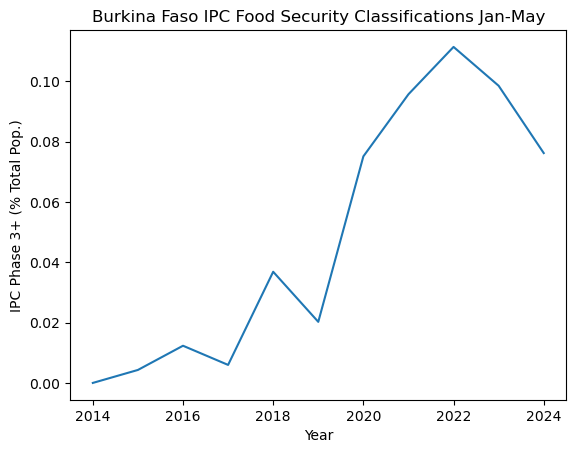

In [ ]:
plt.plot((phase3plus_per),label="Current Phase 3+")
plt.title(country + " IPC Food Security Classifications"+" "+season)
plt.xlabel("Year")
plt.ylabel("IPC Phase 3+ (% Total Pop.)")

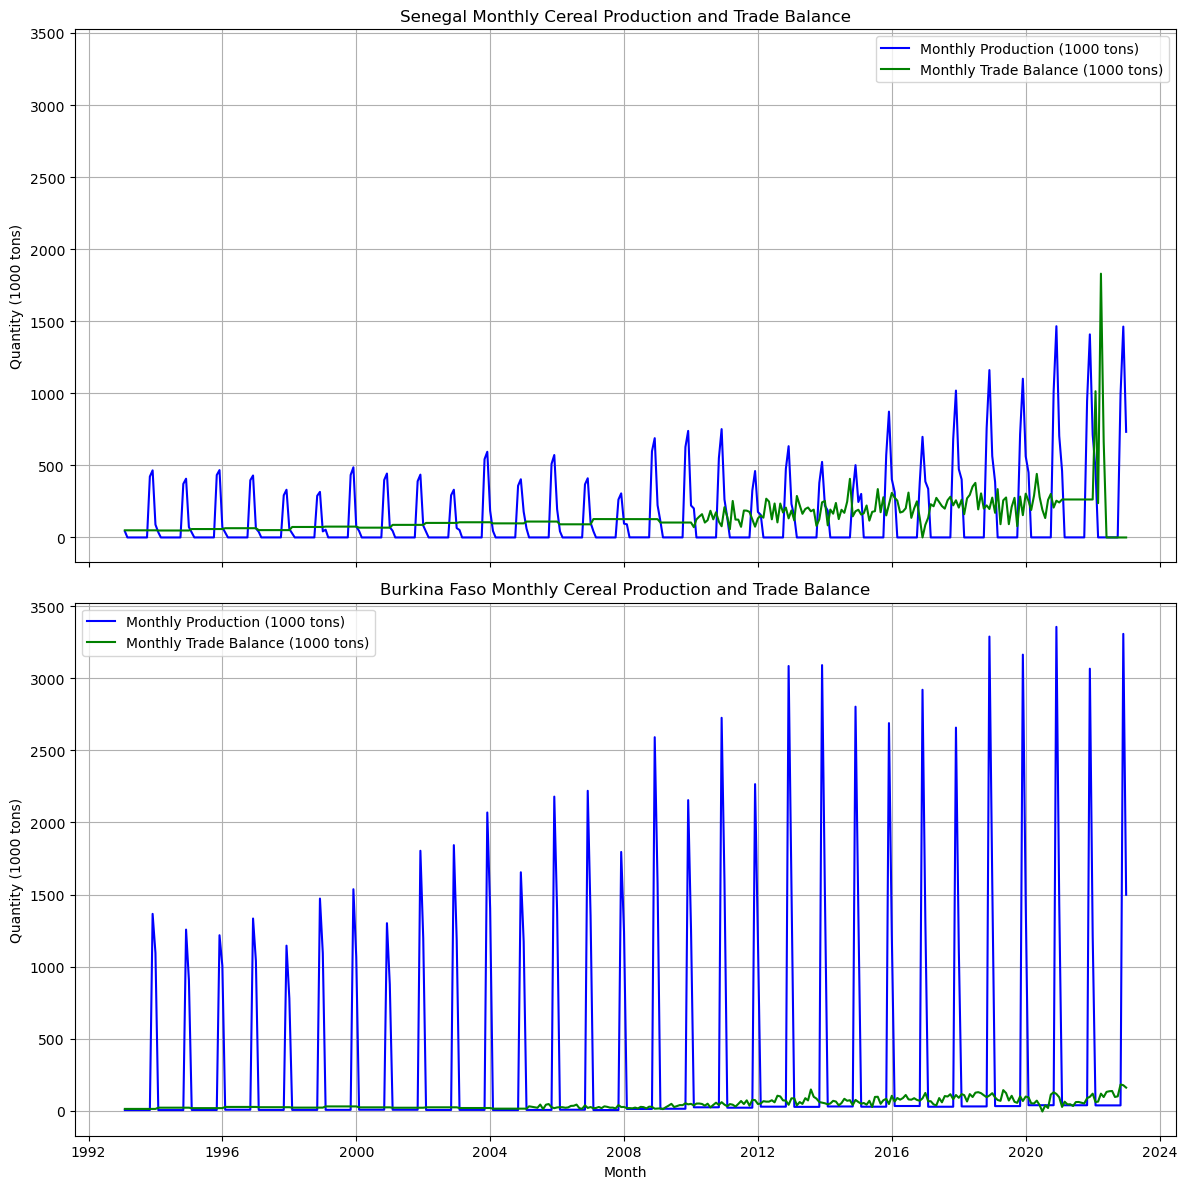

In [ ]:
# Assuming monthly_production and monthly_trade_balance were stored during the calculation in CELL 83
# Initialize storage if not done in CELL 83 (for demonstration)

#national_years = FBS_Cereals_Complete_National.Year.unique()
#national_years = national_years[40:-3] # Should be [2018, 2019] based on CELL 83 context


monthly_production = np.zeros((len(target_nations), len(national_years)*12))
monthly_trade_balance = np.zeros((len(target_nations), len(national_years)*12))

# --- Re-run the calculation part from CELL 83 to populate the arrays ---
# This part is duplicated for context, assuming it wasn't modified to store the values
cereal_caloric_density = 2609*1000 # kcal/ton
caloric_requirment = 1240*365/12 # 1200 kcal/month


for r,region in enumerate(target_nations):
    seed = 0.03
    loss = 0.04
    for i,year in enumerate(national_years):
        for month in np.arange(12):
            processing = 0
            economic_use = 0
            # Interpolate population
            pop_start = National_Populations[(National_Populations.Year == year) & (National_Populations.Area == region ) & (National_Populations.Element == 'Total Population - Both sexes')].Value.values[0]
            pop_end = National_Populations[(National_Populations.Year == year+1) & (National_Populations.Area == region ) & (National_Populations.Element == 'Total Population - Both sexes')].Value.values[0]
            Pop = 1000 * (pop_start + (month/12)*(pop_end - pop_start))

            residuals = 0
            Y = 0
            production_items = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year)&(FBS_Cereals_Complete_National.Element =='Production') & (FBS_Cereals_Complete_National.Area == region)]
            for idx_item, row in production_items.iterrows():
                cereal_item = row['Item']
                production_value = row['Value']
                crop_short = cereal_item.split(' ')[0]
                try:
                    # Find the crop calendar entry, handling potential multiple entries by taking the first
                    calendar_entry = national_crop_calendar[(national_crop_calendar.name0_shr == region)&(national_crop_calendar.crop_name == crop_short)]
                    if not calendar_entry.empty:
                         harvest_percentage = calendar_entry.monthly_harvest_proportions.iloc[0][month]
                    else: # If no specific calendar, assume uniform distribution
                        harvest_percentage = 1/12
                except Exception as e:
                    # print(f"Error finding crop calendar for {region}, {crop_short}, {year}: {e}. Assuming uniform harvest.")
                    harvest_percentage = 1/12 # Default if error
                Y += 1000 * harvest_percentage * production_value # Production in tons

            # Calculate monthly trade proportion
            trade_proportion = 1/12 # Default to uniform distribution
            try:
                # Check if monthly trade data exists for the year and region
                monthly_trade_df = Senegal_Monthly_Trade
                if year in monthly_trade_df[monthly_trade_df.reporterDesc==region].refYear.unique():
                    Imports_month = monthly_trade_df[(monthly_trade_df.flowDesc == "Import")&(monthly_trade_df.partnerDesc == "World")&(monthly_trade_df.refYear == year) & (monthly_trade_df.refMonth == month + 1) & (monthly_trade_df.reporterDesc == region)].netWgt.sum() / 1000 # Convert kg to tons
                    Exports_month = monthly_trade_df[(monthly_trade_df.flowDesc == "Export")&(monthly_trade_df.partnerDesc == "World")&(monthly_trade_df.refYear == year) & (monthly_trade_df.refMonth == month + 1) & (monthly_trade_df.reporterDesc == region)].netWgt.sum() / 1000 # Convert kg to tons
                    # Get total annual trade from FBS for proportion calculation base
                    Imports_year = monthly_trade_df[(monthly_trade_df.flowDesc == "Import")&(monthly_trade_df.partnerDesc == "World")&(monthly_trade_df.refYear == year) & (monthly_trade_df.reporterDesc == region)].netWgt.sum() / 1000 # tons
                    Exports_year = monthly_trade_df[(monthly_trade_df.flowDesc == "Export")&(monthly_trade_df.partnerDesc == "World")&(monthly_trade_df.refYear == year) & (monthly_trade_df.reporterDesc == region)].netWgt.sum() / 1000 # tons
                    total_annual_trade_balance = Imports_year - Exports_year # tons

                    if total_annual_trade_balance != 0:
                         # Use monthly data relative to total annual balance
                         trade_proportion = (Imports_month - Exports_month) / total_annual_trade_balance
                    elif Imports_month == 0 and Exports_month == 0:
                         trade_proportion = 0 # No trade this month
                    else:
                         trade_proportion = 1/12 # Fallback if annual balance is zero but monthly exists

            except Exception as e:
                 # print(f"Error processing trade data for {region}, {year}, {month+1}: {e}. Using uniform trade.")
                 trade_proportion = 1/12 # Fallback

            # Calculate total annual trade balance from FBS
            try:
                annual_imports_fbs = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year)&(FBS_Cereals_Complete_National.Element =='Import quantity') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value * 1000 # tons
                annual_exports_fbs = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year)&(FBS_Cereals_Complete_National.Element =='Export quantity') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value * 1000 # tons
                annual_trade_balance_fbs = annual_imports_fbs - annual_exports_fbs
            except IndexError: # Handle cases where trade data might be missing for a year in FBS
                annual_trade_balance_fbs = 0
                print(f"Warning: FBS trade data missing for {region}, {year}. Assuming zero annual trade balance.")
            if (region =="Angola") & (year == 2015):
                trade_proportion=1/12
            trade_balance = trade_proportion * annual_trade_balance_fbs # Monthly trade balance in tons

            # Store the calculated values
            current_index = 12*i + month
            monthly_production[r, current_index] = Y
            monthly_trade_balance[r, current_index] = trade_balance

            # --- The rest of the stock calculation from CELL 83 would follow here ---
            # (omitted as it's not needed for plotting Y and trade_balance)


# --- Plotting ---
fig, axes = plt.subplots(len(target_nations), 1, figsize=(12, 6 * len(target_nations)), sharex=True, sharey=True)
monthly_time = pd.date_range(start=str(national_years[0]), periods=len(national_years)*12, freq="M") # Correct time axis

for r, region in enumerate(target_nations):
    ax = axes[r]
    ax.plot(monthly_time, monthly_production[r, :] / 1000, label='Monthly Production (1000 tons)', color='blue')
    ax.plot(monthly_time, monthly_trade_balance[r, :] / 1000, label='Monthly Trade Balance (1000 tons)', color='green')
    ax.set_title(f'{region} Monthly Cereal Production and Trade Balance')
    ax.set_ylabel('Quantity (1000 tons)')
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Month')
plt.tight_layout()
plt.show()

['Senegal', 'Burkina Faso']

In [ ]:
country = 'Senegal'
POU_year =  National_Food_Security_Indicators[(National_Food_Security_Indicators.Area ==country  ) &(National_Food_Security_Indicators.Item == "Coefficient of variation of habitual caloric consumption distribution (real number)")].Year.astype(int).values
POU_val = National_Food_Security_Indicators[(National_Food_Security_Indicators.Area == country) &(National_Food_Security_Indicators.Item == "Coefficient of variation of habitual caloric consumption distribution (real number)")].Value.astype(float).values
plt.plot(POU_year,POU_val)
plt.xlim(POU_year[0],POU_year[-1])


In [ ]:
region = "Angola"
for year in np.arange(2010,2023):
    year_sum = 0
    for month in range(12):
                print(year)
                annual_imports_fbs = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year)&(FBS_Cereals_Complete_National.Element =='Import quantity') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value * 1000 # tons
                annual_exports_fbs = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year)&(FBS_Cereals_Complete_National.Element =='Export quantity') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value * 1000 # tons
                annual_trade_balance_fbs = annual_imports_fbs - annual_exports_fbs
                #print(year,annual_trade_balance_fbs)
                Imports_month = monthly_trade_df[(monthly_trade_df.flowDesc == "Import")&(monthly_trade_df.partnerDesc == "World")&(monthly_trade_df.refYear == year) & (monthly_trade_df.refMonth == month + 1) & (monthly_trade_df.reporterDesc == region)].netWgt.sum() / 1000 # Convert kg to tons
                Exports_month = monthly_trade_df[(monthly_trade_df.flowDesc == "Export")&(monthly_trade_df.partnerDesc == "World")&(monthly_trade_df.refYear == year) & (monthly_trade_df.refMonth == month + 1) & (monthly_trade_df.reporterDesc == region)].netWgt.sum() / 1000 # Convert kg to tons
                # Get total annual trade from FBS for proportion calculation base
                Imports_year = monthly_trade_df[(monthly_trade_df.flowDesc == "Import")&(monthly_trade_df.partnerDesc == "World")&(monthly_trade_df.refYear == year) & (monthly_trade_df.reporterDesc == region)].netWgt.sum() / 1000 # tons
                Exports_year = monthly_trade_df[(monthly_trade_df.flowDesc == "Export")&(monthly_trade_df.partnerDesc == "World")&(monthly_trade_df.refYear == year) & (monthly_trade_df.reporterDesc == region)].netWgt.sum() / 1000 # tons
                year_sum +=Imports_month-Exports_month
                total_annual_trade_balance = Imports_year - Exports_year # tons
                plt.scatter(year-2014+month/12,year_sum/total_annual_trade_balance)
                if month == 11:
                       print((year_sum)/total_annual_trade_balance)


# Sensitivity to Minimal Caloric Requirement
# Dietary Composition Analysis 

In [ ]:
import pandas as pd
labels = pd.read_excel(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM-National\GDD 2018 Codebook_Jan 10 2022.xlsx")

In [ ]:
test=pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM-National\Country-level estimates\v01_cnty.csv")

for each file in "..\Data\1DSUM-National\Country-level estimates", process the files where filename of [0:4]  = v04 or v05 or v06 or v07 or v08 [corresponding to the plaintext food type gdd_labels[gdd_labels["Dietary factor" == filename[0:4]]]["Unnamed: 1"]]. 

make a dataframe with dietary factor, country, year, median, upperci_95, lowerci_95
these can be gathered as follows:
nostatification_indices = (test["age"]==999.0) & (test["female"]==999) & (test["urban"]==999)&(test["edu"]==999)
gdd_country_mediancons=test[(test["iso3"]=="SEN")&(nostatification_indices)].drop(["age","female","urban","edu"],axis=1)["median"] #andupperci_95, lower...
gdd_country_years=test[(test["iso3"]=="SEN")&(nostatification_indices)].drop(["age","female","urban","edu"],axis=1)["year"]


In [ ]:
import os
import glob
import pandas as pd
import country_converter as coco
cc = coco.CountryConverter()

# Define the directory path and target variable codes
data_dir = r"..\Data\1DSUM-National\Country-level estimates"
target_vars = ['v01','v04', 'v05', 'v06', 'v07', 'v08','v09','v10','v11','v57','v03','v12','v13','v14','v15','v16']  # List of target variable codes
kcal_gram = {'v01':20,'v04': 100, 'v05': 340, 'v06':400, 'v07': 350, 'v08': 340,'v09':150,'v10':200,'v11':150,'v57':50,'v03':80,'v12':140,'v13':200,'v14':61,'v15':40,'v16':55}   #units: per 100 grams. source: group averages from https://www.fao.org/4/x9892e/X9892e05.htm

# Initialize empty list to store all data
all_dietary_data = []

# Process each target variable file
for var_code in target_vars:
    # Find files matching the pattern
    file_pattern = os.path.join(data_dir, f"{var_code}_cnty.csv")
    matching_files = glob.glob(file_pattern)
    
    for file_path in matching_files:
        try:
            # Read the CSV file
            df = pd.read_csv(file_path)
            
            # Get the dietary factor name from labels dataframe
            dietary_factor_name = labels[labels["Dietary factor"] == var_code]["Unnamed: 1"].iloc[0]
            print(dietary_factor_name + "kcal/100g:" + str(kcal_gram[var_code]) )
            # Define no-stratification indices ## OR ## now allowing urban/rural stratification
            nostatification_indices = (df["age"]==999.0) & (df["female"]==999) & (df["edu"]==999) #& (df["urban"]==999) 
            
            # Filter data for non-stratified estimates
            filtered_df = df[nostatification_indices].copy()

            # Add dietary factor column
            filtered_df['dietary_factor'] = dietary_factor_name
            
            # Select relevant columns
            processed_df = filtered_df[['dietary_factor', 'iso3', 'year', 'median', 'upperci_95', 'lowerci_95','serving','urban']].copy()
            
            # Rename iso3 to country for clarity
            processed_df = processed_df.rename(columns={'iso3': 'country'})
            #add column for calorie conversion
            processed_df["calories_day"]= processed_df["median"] * kcal_gram[var_code]/100 #gdd data is in grams/day/person. nutrition data from fao reported in kcal/100grams
            # Append to main list
            all_dietary_data.append(processed_df)
            
            print(f"Processed {var_code} ({dietary_factor_name}): {len(processed_df)} records")
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# Combine all dataframes
if all_dietary_data:
    dietary_consumption_df = pd.concat(all_dietary_data, ignore_index=True)
    
    # Display summary
    print(f"\nFinal dataset shape: {dietary_consumption_df.shape}")
    print(f"Dietary factors included: {dietary_consumption_df['dietary_factor'].unique()}")
    print(f"Countries included: {len(dietary_consumption_df['country'].unique())}")
    print(f"Year range: {dietary_consumption_df['year'].min()} - {dietary_consumption_df['year'].max()}")
    
    # Show first few rows
    print("\nFirst few rows:")
    print(dietary_consumption_df.head())
    
else:
    print("No data files found or processed successfully")
print("Converting country codes to short names...")
dietary_consumption_df["country"] = cc.convert(dietary_consumption_df["country"], to='short_name')

Fruitskcal/100g:20
Processed v01 (Fruits): 3885 records
Other starchy vegetableskcal/100g:100
Processed v04 (Other starchy vegetables): 3885 records
Beans and legumeskcal/100g:340
Processed v05 (Beans and legumes): 3885 records
Nuts and seedskcal/100g:400
Processed v06 (Nuts and seeds): 3885 records
Refined grainskcal/100g:350
Processed v07 (Refined grains): 3885 records
Whole grainskcal/100g:340
Processed v08 (Whole grains): 3885 records
Total processed meatskcal/100g:150
Processed v09 (Total processed meats): 3885 records
Unprocessed red meatskcal/100g:200
Processed v10 (Unprocessed red meats): 4440 records
Total seafoodskcal/100g:150
Processed v11 (Total seafoods): 3885 records
Total Milkkcal/100g:50
Processed v57 (Total Milk): 3885 records
Potatoeskcal/100g:80
Processed v03 (Potatoes): 3885 records
Eggskcal/100g:140
Processed v12 (Eggs): 3885 records
Cheesekcal/100g:200
Processed v13 (Cheese): 3885 records
Yoghurt (including fermented milk)kcal/100g:61
Processed v14 (Yoghurt (inclu

In [ ]:
# Calculate relative dietary importance of cereals: servings of cereals / servings of other foods

# Filter for cereals data
cereals_data = dietary_consumption_df[dietary_consumption_df['dietary_factor'].str.contains('grains', case=False, na=False)]

# Calculate total servings for cereals by country and year
cereals_servings = cereals_data.groupby(['country', 'year'])['serving'].sum().reset_index()
cereals_servings.columns = ['country', 'year', 'cereals_servings']

# Calculate total servings for all foods by country and year
total_servings = dietary_consumption_df.groupby(['country', 'year'])['serving'].sum().reset_index()
total_servings.columns = ['country', 'year', 'total_servings']

#
# Calculate other foods servings (total - cereals)
#
dietary_importance = cereals_servings.merge(total_servings, on=['country', 'year'])
dietary_importance['other_servings'] = dietary_importance['total_servings'] - dietary_importance['cereals_servings']

# Calculate relative importance ratio: cereals servings / other foods servings
dietary_importance['cereals_relative_importance'] = dietary_importance['cereals_servings'] / dietary_importance['total_servings']

# Display results
print("Relative Dietary Importance of Cereals (cereals servings / other foods servings):")
print(dietary_importance[['country', 'year', 'cereals_relative_importance']].head(10))

# Show summary statistics
print(f"\nSummary statistics for cereals relative importance:")
print(dietary_importance['cereals_relative_importance'].describe())

Relative Dietary Importance of Cereals (cereals servings / other foods servings):
       country  year  cereals_relative_importance
0  Afghanistan  1990                     0.591990
1  Afghanistan  1995                     0.631757
2  Afghanistan  2000                     0.585143
3  Afghanistan  2005                     0.528339
4  Afghanistan  2010                     0.423334
5  Afghanistan  2015                     0.380601
6  Afghanistan  2018                     0.323263
7      Albania  1990                     0.607293
8      Albania  1995                     0.502574
9      Albania  2000                     0.393465

Summary statistics for cereals relative importance:
count    1295.000000
mean        0.354837
std         0.118962
min         0.042572
25%         0.276539
50%         0.343175
75%         0.428786
max         0.732896
Name: cereals_relative_importance, dtype: float64


In [ ]:
total_servings.country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo Republic', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'DR Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada',
       'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti',
 

### Cereals importance

In [ ]:
# Filter for Sub-Saharan Africa countries and calculate average cereals relative importance
ssa_countries = ['Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 
                 'Cabo Verde', 'Central African Republic', 'Chad', 'Comoros', 
                 'Congo', 'Democratic Republic of the Congo', 'Côte d\'Ivoire', 
                 'Djibouti', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 
                 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 
                 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 
                 'Mauritius', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 
                 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 
                 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 
                 'Togo', 'Uganda', 'Zambia', 'Zimbabwe']

# Filter dietary importance data for SSA countries
ssa_dietary_importance = dietary_importance[dietary_importance['country'].isin(ssa_countries)]

# Calculate average cereals relative importance by country
ssa_cereals_importance = ssa_dietary_importance.groupby('country').agg({
    'cereals_relative_importance': 'mean',
    'year': ['min', 'max', 'count']
}).round(3)

# Flatten column names
ssa_cereals_importance.columns = ['Avg_Cereals_Relative_Importance', 'First_Year', 'Last_Year', 'Years_Available']

# Reset index to make country a column
ssa_cereals_importance = ssa_cereals_importance.reset_index()

# Sort by average cereals relative importance (descending)
ssa_cereals_importance = ssa_cereals_importance.sort_values('Avg_Cereals_Relative_Importance', ascending=False)

print("Average Cereals Relative Importance for Sub-Saharan Africa Countries")
print("=" * 80)
print(ssa_cereals_importance.to_string(index=False))

# Display summary statistics
print(f"\nSummary Statistics:")
print(f"Number of SSA countries with data: {len(ssa_cereals_importance)}")
print(f"Mean cereals relative importance: {ssa_cereals_importance['Avg_Cereals_Relative_Importance'].mean():.3f}")
print(f"Median cereals relative importance: {ssa_cereals_importance['Avg_Cereals_Relative_Importance'].median():.3f}")
print(f"Standard deviation: {ssa_cereals_importance['Avg_Cereals_Relative_Importance'].std():.3f}")

Average Cereals Relative Importance for Sub-Saharan Africa Countries
                 country  Avg_Cereals_Relative_Importance  First_Year  Last_Year  Years_Available
                Ethiopia                            0.638        1990       2018                7
                Tanzania                            0.623        1990       2018                7
                  Malawi                            0.553        1990       2018                7
                Zimbabwe                            0.545        1990       2018                7
                 Nigeria                            0.521        1990       2018                7
            Burkina Faso                            0.517        1990       2018                7
              Madagascar                            0.504        1990       2018                7
                 Eritrea                            0.500        1990       2018                7
             South Sudan                         

In [31]:
#nonstatified cereals consumption in Angola
dietary_consumption_df[
    (dietary_consumption_df['dietary_factor'].isin(['Refined grains', 'Whole grains']))#,'Other starchy vegetables', 'Beans and legumes', 'Nuts and seeds'])
    &(dietary_consumption_df['country'].isin(['Burkina Faso'])) & (dietary_consumption_df['urban']== 0)
].groupby("year").sum().calories_day * np.array(284/217)


year
1990     977.486310
1995     958.931078
2000     992.007623
2005     971.437433
2010    1005.050458
2015     976.095144
2018     962.511083
Name: calories_day, dtype: float64

In [309]:
x=np.vstack(np.random.random((4,4))*10)

x

array([[0.77580531, 7.76863268, 6.97701062, 1.48141284],
       [7.34711004, 2.37129457, 8.51095119, 3.36092068],
       [5.8074068 , 0.73199312, 7.83826809, 9.65345808],
       [2.90452719, 1.93224969, 3.13864779, 5.7458872 ]])

In [314]:
np.minimum(np.ones(4),0)

array([0., 0., 0., 0.])

In [266]:
#urban cereals consumption in Angola
dietary_consumption_df[
    (dietary_consumption_df['dietary_factor'].isin(['Refined grains', 'Whole grains']))#,'Other starchy vegetables', 'Beans and legumes', 'Nuts and seeds'])
    &(dietary_consumption_df['country'].isin(['Angola'])) & (dietary_consumption_df['urban']== 1)
].groupby("year").sum().calories_day.values


array([1235.57435709,  570.3294656 ,  762.32597747,  992.79768507,
        999.58669148, 1064.1079834 , 1005.40626418])

In [267]:
#rural cereals consumption in Angola
dietary_consumption_df[
    (dietary_consumption_df['dietary_factor'].isin(['Refined grains', 'Whole grains']))#,'Other starchy vegetables', 'Beans and legumes', 'Nuts and seeds'])
    &(dietary_consumption_df['country'].isin(['Angola'])) & (dietary_consumption_df['urban']== 0)
].groupby("year").sum().calories_day.values

array([1136.9286128 ,  519.4468148 ,  695.64205331,  908.12902128,
        914.19500358,  974.00806336,  921.32922377])

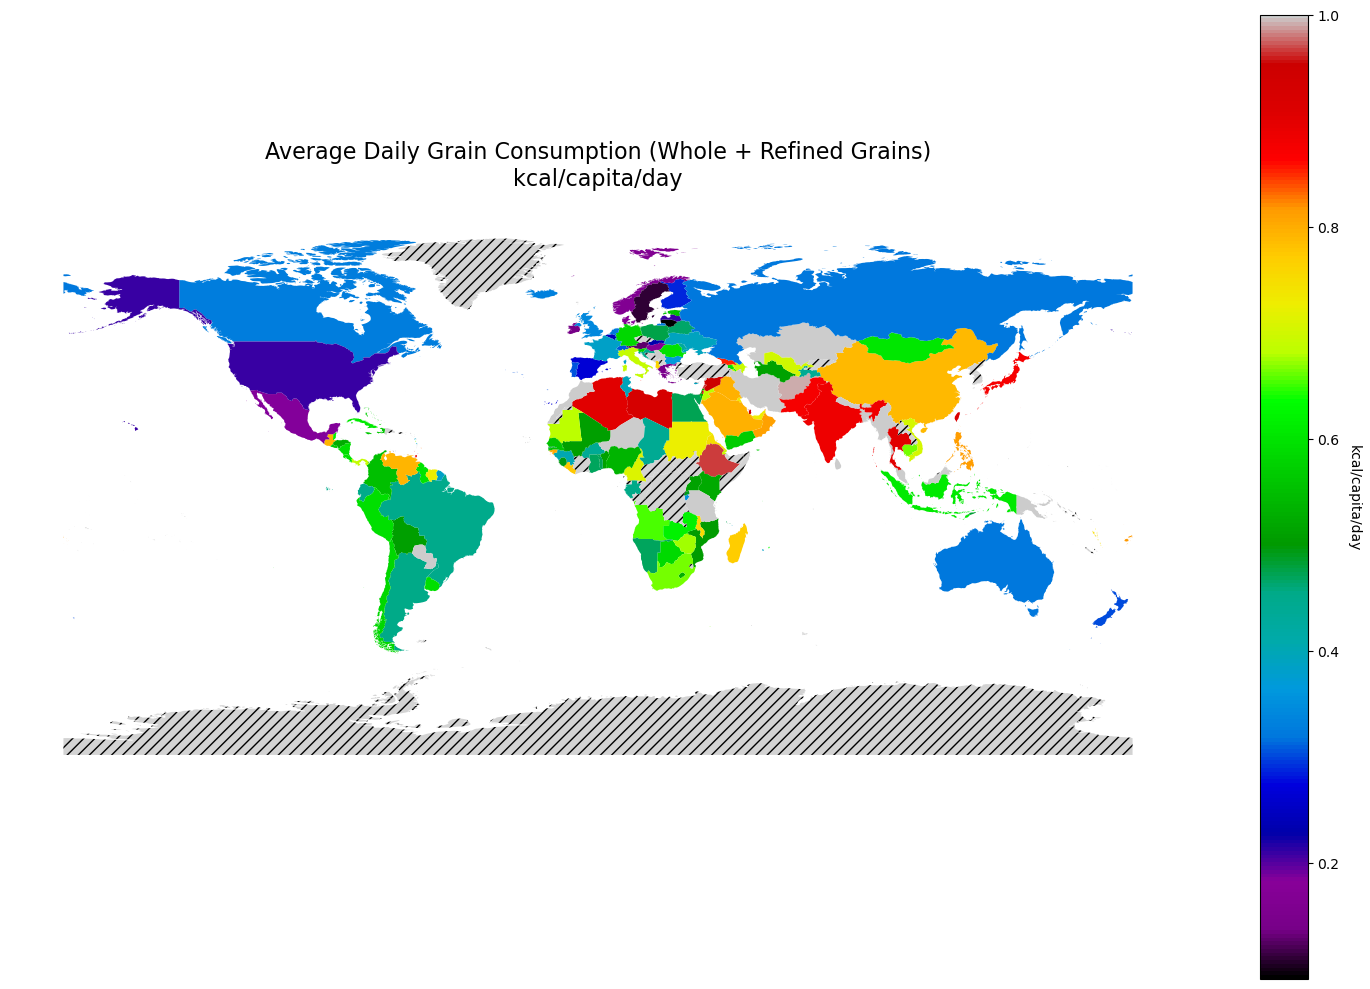

Countries with data: 185
Average grain consumption range: 0.1 - 2.0 kcal/day
Global average: 0.7 kcal/day


In [232]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Filter for whole grains and refined grains
grains_data = dietary_consumption_df[
    dietary_consumption_df['dietary_factor'].isin(['Refined grains', 'Whole grains'])#,'Other starchy vegetables', 'Beans and legumes', 'Nuts and seeds'])
]

# Calculate total grain calories by country (sum of whole + refined grains)
total_grains = grains_data.groupby(['country', 'year'])['calories_day'].sum().reset_index()

# Calculate interannual average for each country
avg_grains = total_grains.groupby('country')['calories_day'].max().reset_index()
avg_grains.columns = ['country', 'avg_grain_calories']
avg_grains["avg_grain_calories"] = avg_grains["avg_grain_calories"]/1800
# Load world map data
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = gpd.read_file(
    "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"
)
# Merge with grain data
world_grains = world.merge(avg_grains, left_on='name', right_on='country', how='left')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the world map with grain calorie data
world_grains.plot(column='avg_grain_calories', 
                  cmap='nipy_spectral', 
                  legend=True,
                  vmax=1,
                  ax=ax,
                  missing_kwds={'color': 'lightgrey',
                                 'hatch': '///'
                                 })

ax.set_title('Average Daily Grain Consumption (Whole + Refined Grains)\nkcal/capita/day', 
             fontsize=16, pad=20)
ax.set_axis_off()

# Add colorbar label
cbar = ax.get_figure().get_axes()[-1]
cbar.set_ylabel('kcal/capita/day', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Print some summary statistics
print(f"Countries with data: {len(avg_grains)}")
print(f"Average grain consumption range: {avg_grains['avg_grain_calories'].min():.1f} - {avg_grains['avg_grain_calories'].max():.1f} kcal/day")
print(f"Global average: {avg_grains['avg_grain_calories'].mean():.1f} kcal/day")

In [233]:
avg_grains[avg_grains.country == "Angola"].avg_grain_calories * 1800

3    1173.331715
Name: avg_grain_calories, dtype: float64

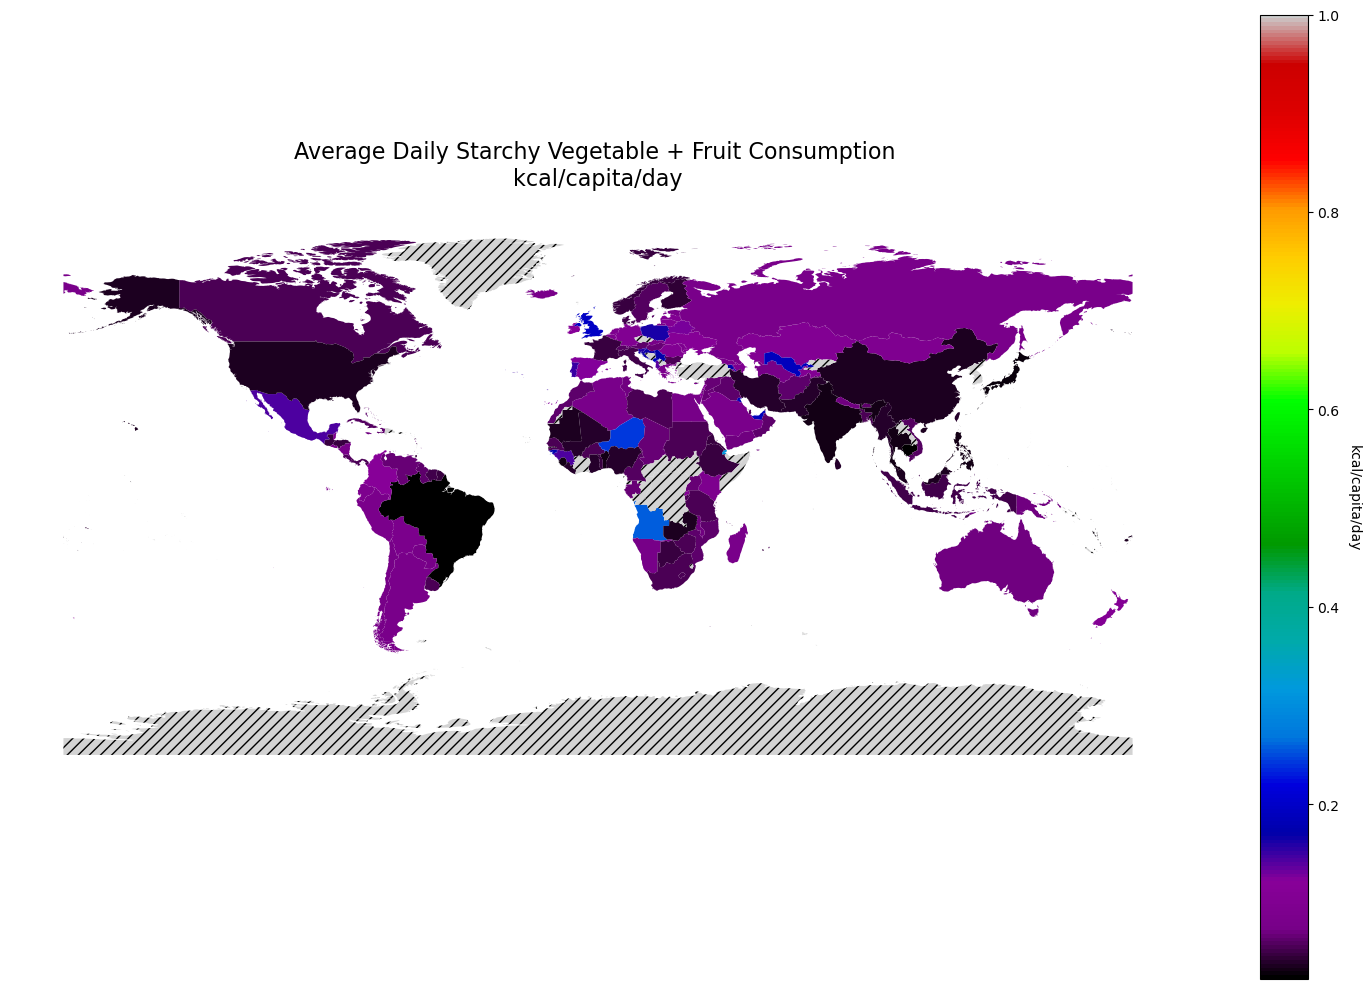

Countries with data: 185
Average grain consumption range: 0.0 - 0.3 kcal/day
Global average: 0.1 kcal/day
Top 20 countries by average starchy good consumption:
                    country  avg_grain_calories
46                 Djibouti            0.311693
3                    Angola            0.258990
120                   Niger            0.243616
175          United Kingdom            0.196740
111              Montenegro            0.191001
178              Uzbekistan            0.190741
174    United Arab Emirates            0.188598
88                   Kuwait            0.180523
69            Guinea-Bissau            0.177030
6                   Armenia            0.171135
142                  Serbia            0.170020
40                  Croatia            0.167073
132                  Poland            0.161757
147                Slovenia            0.156554
20   Bosnia and Herzegovina            0.154470
133                Portugal            0.151959
68                   Gui

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

grains_data = dietary_consumption_df[
    dietary_consumption_df['dietary_factor'].isin(['Potatoes','Other starchy vegetables','Fruits'])#,'Other starchy vegetables', 'Beans and legumes', 'Nuts and seeds'])
]

# Calculate total grain calories by country (sum of whole + refined grains)
total_grains = grains_data.groupby(['country', 'year'])['calories_day'].sum().reset_index()

# Calculate interannual average for each country
avg_grains = total_grains.groupby('country')['calories_day'].max().reset_index()
avg_grains.columns = ['country', 'avg_grain_calories']
avg_grains["avg_grain_calories"] = avg_grains["avg_grain_calories"]/1800
# Load world map data
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = gpd.read_file(
    "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"
)
# Merge with grain data
world_grains = world.merge(avg_grains, left_on='name', right_on='country', how='left')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the world map with grain calorie data
world_grains.plot(column='avg_grain_calories', 
                  cmap='nipy_spectral', 
                  legend=True,
                  vmax=1,
                  ax=ax,
                  missing_kwds={'color': 'lightgrey',
                                 'hatch': '///'
                                 })
ax.set_title('Average Daily Starchy Vegetable + Fruit Consumption \nkcal/capita/day', 
             fontsize=16, pad=20)
ax.set_axis_off()

# Add colorbar label
cbar = ax.get_figure().get_axes()[-1]
cbar.set_ylabel('kcal/capita/day', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Print some summary statistics
print(f"Countries with data: {len(avg_grains)}")
print(f"Average grain consumption range: {avg_grains['avg_grain_calories'].min():.1f} - {avg_grains['avg_grain_calories'].max():.1f} kcal/day")
print(f"Global average: {avg_grains['avg_grain_calories'].mean():.1f} kcal/day")
# Print top 20 countries by average grain calories consumption
print("Top 20 countries by average starchy good consumption:")
print(avg_grains.nlargest(40, 'avg_grain_calories'))

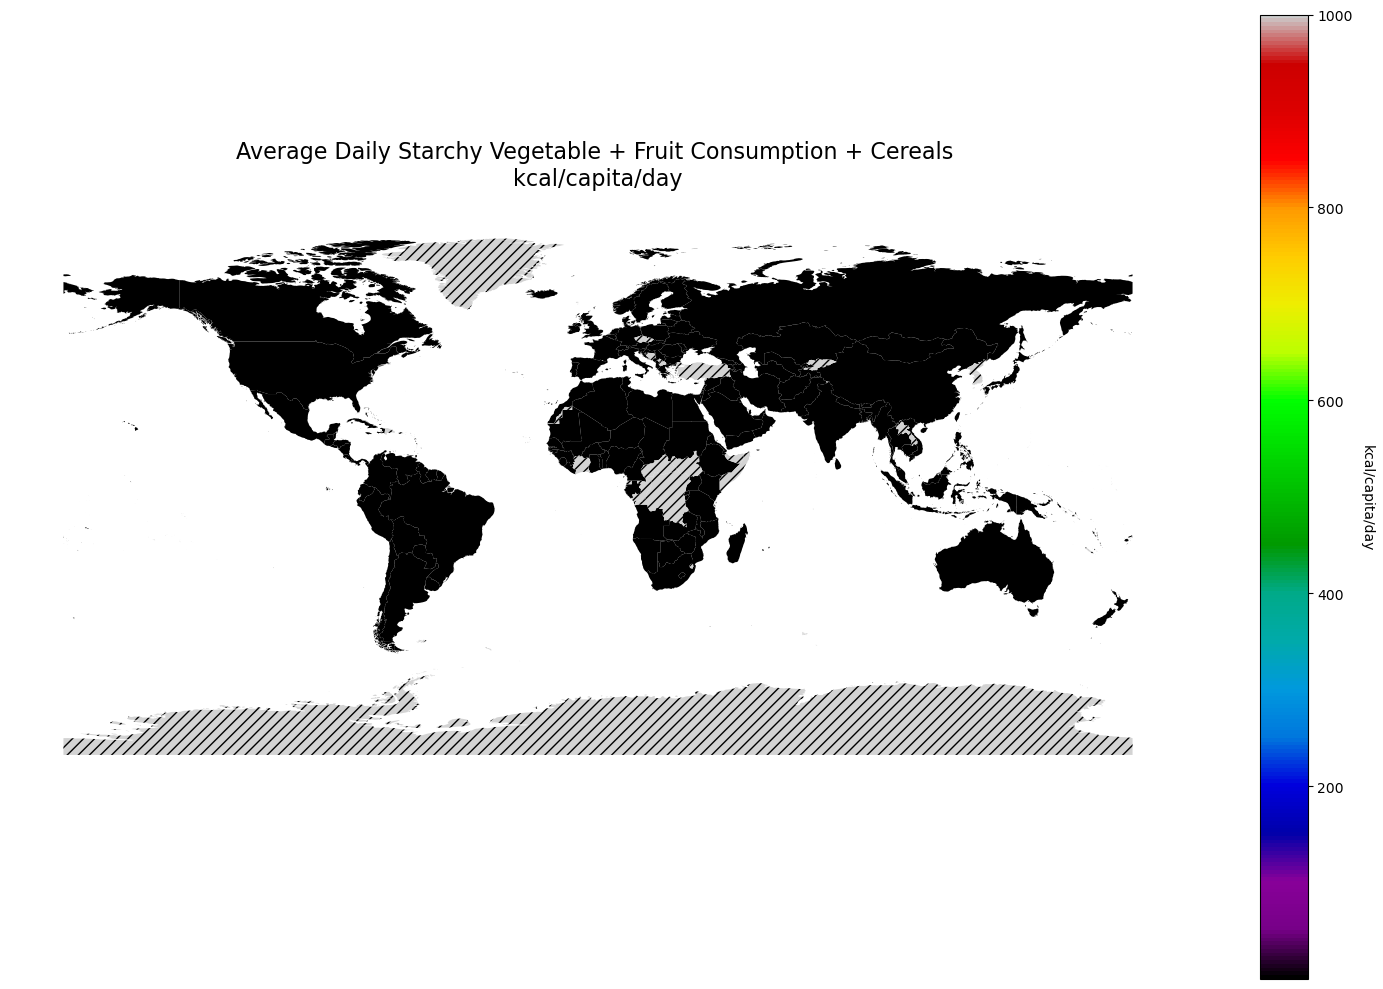

Countries with data: 185
Average grain consumption range: 0.2 - 2.0 kcal/day
Global average: 0.7 kcal/day
Top 20 countries by average starchy good + cereal consumption:
                   country  avg_grain_calories
138                  Samoa            1.989707
85              Kazakhstan            1.899505
18                  Bhutan            1.527401
90                    Laos            1.504384
142                 Serbia            1.488517
120                  Niger            1.484224
100               Malaysia            1.321296
12              Bangladesh            1.289971
153              Sri Lanka            1.265343
101               Maldives            1.255879
108  Micronesia, Fed. Sts.            1.233294
87                Kiribati            1.226044
112                Morocco            1.209314
167                  Tonga            1.187192
104       Marshall Islands            1.186267
145              Singapore            1.165937
128       Papua New Guinea      

In [158]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Filter for whole grains and refined grains
grains_data = dietary_consumption_df[
    dietary_consumption_df['dietary_factor'].isin(['Nuts and seeds','Refined grains','Whole grains','Potatoes','Other starchy vegetables','Fruits'])#,'Other starchy vegetables', 'Beans and legumes', 'Nuts and seeds'])
]

# Calculate total grain calories by country (sum of whole + refined grains)
total_grains = grains_data.groupby(['country', 'year'])['calories_day'].sum().reset_index()

# Calculate interannual average for each country
avg_grains = total_grains.groupby('country')['calories_day'].max().reset_index()
avg_grains.columns = ['country', 'avg_grain_calories']
avg_grains["avg_grain_calories"] = avg_grains["avg_grain_calories"]/1800
# Load world map data
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = gpd.read_file(
    "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"
)
# Merge with grain data
world_grains = world.merge(avg_grains, left_on='name', right_on='country', how='left')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the world map with grain calorie data
world_grains.plot(column='avg_grain_calories', 
                  cmap='nipy_spectral', 
                  legend=True,
                  vmax=1000,
                  ax=ax,
                  missing_kwds={'color': 'lightgrey',
                                 'hatch': '///'
                                 })
ax.set_title('Average Daily Starchy Vegetable + Fruit Consumption + Cereals \nkcal/capita/day', 
             fontsize=16, pad=20)
ax.set_axis_off()

# Add colorbar label
cbar = ax.get_figure().get_axes()[-1]
cbar.set_ylabel('kcal/capita/day', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Print some summary statistics
print(f"Countries with data: {len(avg_grains)}")
print(f"Average grain consumption range: {avg_grains['avg_grain_calories'].min():.1f} - {avg_grains['avg_grain_calories'].max():.1f} kcal/day")
print(f"Global average: {avg_grains['avg_grain_calories'].mean():.1f} kcal/day")
# Print top 20 countries by average grain calories consumption
print("Top 20 countries by average starchy good + cereal consumption:")
print(avg_grains.nlargest(40, 'avg_grain_calories'))

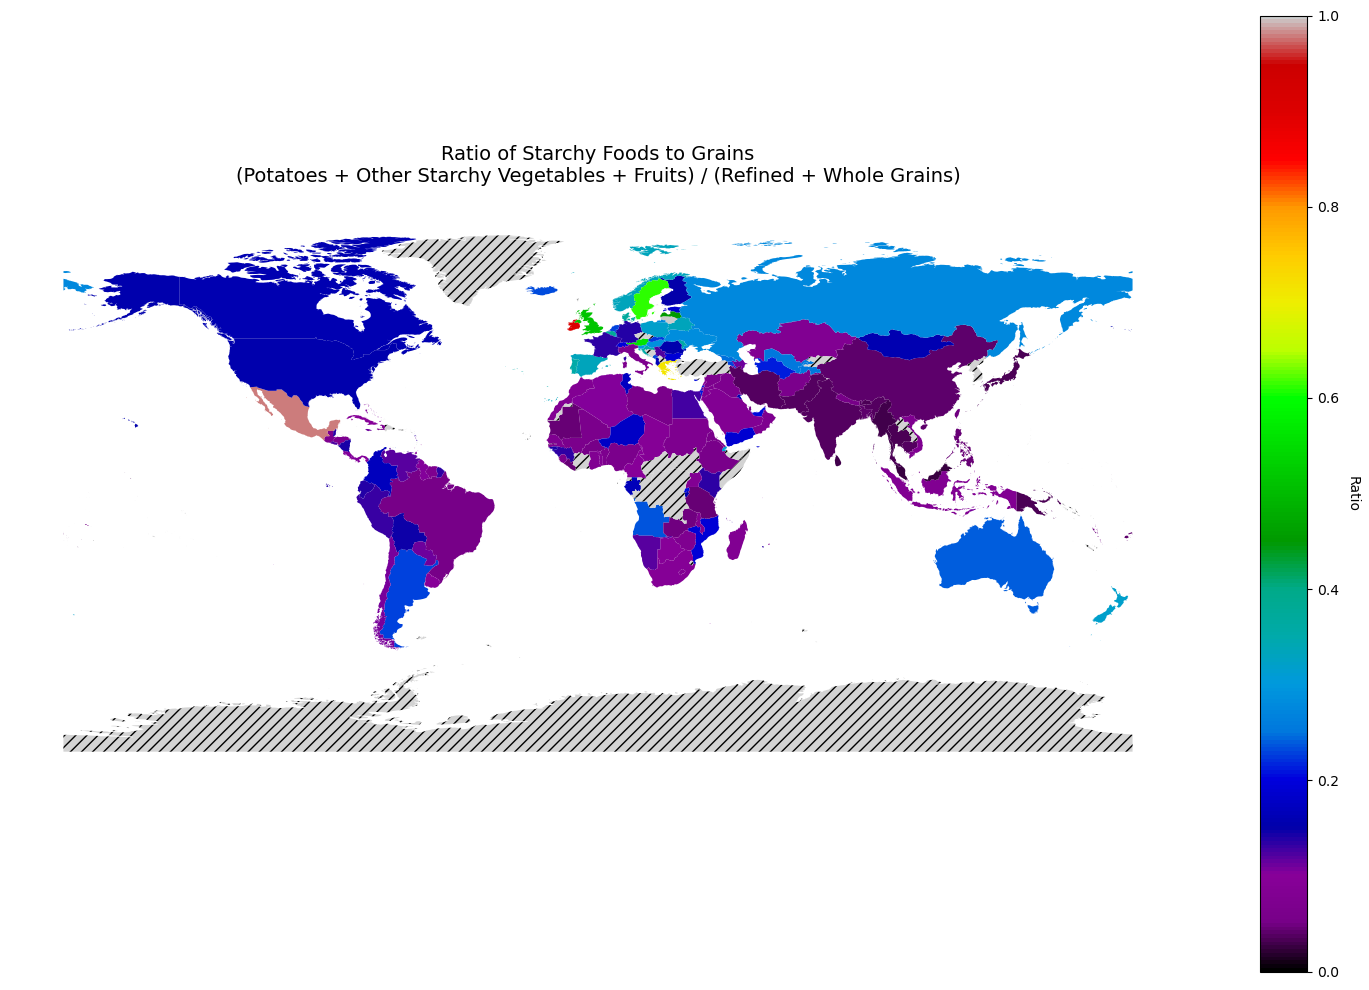

Countries with data: 185
Ratio range: 0.02 - 1.49
Global average ratio: 0.16

Top 10 countries by starchy-to-grain ratio:
            country  avg_starchy_grain_ratio
96        Lithuania                 1.486562
107          Mexico                 0.978022
79          Ireland                 0.906021
65           Greece                 0.713397
43          Czechia                 0.673646
158          Sweden                 0.611473
8           Austria                 0.559270
175  United Kingdom                 0.513427
91           Latvia                 0.450482
44         DR Congo                 0.409867

Bottom 10 countries by starchy-to-grain ratio:
               country  avg_starchy_grain_ratio
90                Laos                 0.015434
150        South Korea                 0.026680
100           Malaysia                 0.027332
104   Marshall Islands                 0.027883
87            Kiribati                 0.029442
153          Sri Lanka                 0.030157

In [132]:
# Filter for starchy vegetables, potatoes, fruits, and grains
starchy_data = dietary_consumption_df[
    dietary_consumption_df['dietary_factor'].isin(['Potatoes', 'Other starchy vegetables', 'Fruits'])
]

grains_data_ratio = dietary_consumption_df[
    dietary_consumption_df['dietary_factor'].isin(['Refined grains', 'Whole grains'])
]

# Calculate total calories for starchy foods by country and year
total_starchy = starchy_data.groupby(['country', 'year'])['calories_day'].sum().reset_index()
total_starchy.columns = ['country', 'year', 'starchy_calories']

# Calculate total calories for grains by country and year
total_grains_ratio = grains_data_ratio.groupby(['country', 'year'])['calories_day'].sum().reset_index()
total_grains_ratio.columns = ['country', 'year', 'grain_calories']

# Merge the datasets
merged_ratio = total_starchy.merge(total_grains_ratio, on=['country', 'year'], how='inner')

# Calculate the ratio of starchy foods to grains
merged_ratio['starchy_to_grain_ratio'] = merged_ratio['starchy_calories'] / merged_ratio['grain_calories']

# Calculate average ratio for each country (handling potential infinities)
avg_ratio = merged_ratio.groupby('country')['starchy_to_grain_ratio'].mean().reset_index()
avg_ratio.columns = ['country', 'avg_starchy_grain_ratio']

# Replace infinite values with NaN for better visualization
avg_ratio['avg_starchy_grain_ratio'] = avg_ratio['avg_starchy_grain_ratio'].replace([np.inf, -np.inf], np.nan)

# Load world map data and merge with ratio data
world_ratio = world.merge(avg_ratio, left_on='name', right_on='country', how='left')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the world map with starchy-to-grain ratio data
world_ratio.plot(column='avg_starchy_grain_ratio', 
                 cmap='nipy_spectral', 
                 legend=True,
                 vmin=0,
                 vmax=1,
                 ax=ax,
                 missing_kwds={'color': 'lightgrey',
                              'hatch': '///'})

ax.set_title('Ratio of Starchy Foods to Grains\n(Potatoes + Other Starchy Vegetables + Fruits) / (Refined + Whole Grains)', 
             fontsize=14, pad=20)
ax.set_axis_off()

# Add colorbar label
cbar = ax.get_figure().get_axes()[-1]
cbar.set_ylabel('Ratio', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Countries with data: {len(avg_ratio.dropna())}")
print(f"Ratio range: {avg_ratio['avg_starchy_grain_ratio'].min():.2f} - {avg_ratio['avg_starchy_grain_ratio'].max():.2f}")
print(f"Global average ratio: {avg_ratio['avg_starchy_grain_ratio'].mean():.2f}")

# Print top and bottom 10 countries by ratio
print("\nTop 10 countries by starchy-to-grain ratio:")
print(avg_ratio.nlargest(10, 'avg_starchy_grain_ratio'))
print("\nBottom 10 countries by starchy-to-grain ratio:")
print(avg_ratio.nsmallest(10, 'avg_starchy_grain_ratio'))

In [216]:
# Calculate grain servings by country and year
grains_servings = dietary_consumption_df[
    dietary_consumption_df['dietary_factor'].isin(['Refined grains', 'Whole grains'])
].groupby(['country', 'year'])['serving'].sum().reset_index()
grains_servings.columns = ['country', 'year', 'grains_servings']

# Calculate non-grain servings by country and year
non_grains_servings = dietary_consumption_df[
    ~dietary_consumption_df['dietary_factor'].isin(['Refined grains', 'Whole grains'])
].groupby(['country', 'year'])['serving'].sum().reset_index()
non_grains_servings.columns = ['country', 'year', 'non_grains_servings']

# Merge the datasets
merged_servings = grains_servings.merge(non_grains_servings, on=['country', 'year'], how='inner')

# Calculate correlation for each country
country_correlations = []
for country in merged_servings['country'].unique():
    country_data = merged_servings[merged_servings['country'] == country]
    
    if len(country_data) >= 3:  # Need at least 3 data points for meaningful correlation
        correlation = np.corrcoef(country_data['grains_servings'], country_data['non_grains_servings'])[0, 1]
        country_correlations.append({
            'country': country,
            'correlation': correlation,
            'n_years': len(country_data),
            'nongrain_data':country_data.non_grains_servings.values,
            'grain_data':country_data.grains_servings.values
        })

# Convert to DataFrame and sort by correlation
correlations_df = pd.DataFrame(country_correlations)
correlations_df = correlations_df.sort_values('correlation', ascending=False)

print("Correlation between grain servings and non-grain servings by country:")
print(correlations_df.head(20))
print("\nSummary statistics:")
print(correlations_df['correlation'].describe())

Correlation between grain servings and non-grain servings by country:
                      country  correlation  n_years  \
18                     Bhutan     0.962950        7   
151               South Sudan     0.955546        7   
53                    Eritrea     0.954796        7   
134                     Qatar     0.953208        7   
158                    Sweden     0.949179        7   
126                 Palestine     0.936458        7   
102                      Mali     0.929622        7   
160                     Syria     0.927608        7   
11                    Bahrain     0.926474        7   
26                    Burundi     0.923570        7   
107                    Mexico     0.922864        7   
112                   Morocco     0.919483        7   
95                      Libya     0.913600        7   
29                   Cameroon     0.909544        7   
156                     Sudan     0.899183        7   
67                  Guatemala     0.892384        

#### Calculate cereal trade balance to production ratio for each nation over the last 15 years


In [144]:
# Calculate cereal trade balance to production ratio for each nation over the last 15 years

# Filter data for the last 15 years (2009-2023)
recent_years = range(2009, 2024)

# Initialize list to store results
trade_production_ratios = []

# Get unique countries from the FBS data
countries = FBS_Cereals_Complete_National['Area'].unique()

for country in countries:
    # Filter data for current country and recent years
    country_data = FBS_Cereals_Complete_National[
        (FBS_Cereals_Complete_National['Area'] == country) & 
        (FBS_Cereals_Complete_National['Year'].isin(recent_years))
    ]
    
    # Get production data
    production_data = country_data[
        country_data['Element'] == 'Production'
    ].groupby('Year')['Value'].sum()
    
    # Get import data
    import_data = country_data[
        country_data['Element'] == 'Import quantity'
    ].groupby('Year')['Value'].sum()
    
    # Get export data
    export_data = country_data[
        country_data['Element'] == 'Export quantity'
    ].groupby('Year')['Value'].sum()
    
    # Calculate trade balance for each year
    trade_ratios = []
    for year in recent_years:
        if (year in production_data.index and 
            year in import_data.index and 
            year in export_data.index):
            
            production = production_data[year]
            imports = import_data[year]
            exports = export_data[year]
            
            if production > 0:  # Avoid division by zero
                trade_balance = imports - exports
                ratio = trade_balance / production
                trade_ratios.append(ratio)
    
    # Calculate average ratio over available years
    if trade_ratios:
        avg_ratio = np.mean(trade_ratios)
        trade_production_ratios.append({
            'Country': country,
            'Avg_Trade_Production_Ratio': avg_ratio,
            'Years_Available': len(trade_ratios)
        })

# Convert to DataFrame for easier viewing
trade_ratio_df = pd.DataFrame(trade_production_ratios)

# Sort by ratio (descending)
trade_ratio_df = trade_ratio_df.sort_values('Avg_Trade_Production_Ratio', ascending=False)

print("Cereal Trade Balance to Production Ratios (2009-2023 average)")
print("=" * 60)
print(f"{'Country':<25} {'Ratio':<10} {'Years':<5}")
print("-" * 60)

for _, row in trade_ratio_df.iterrows():
    print(f"{row['Country']:<25} {row['Avg_Trade_Production_Ratio']:>7.3f} {row['Years_Available']:>5}")

Cereal Trade Balance to Production Ratios (2009-2023 average)
Country                   Ratio      Years
------------------------------------------------------------
Mauritius                 311.286     7
Cabo Verde                 46.719    11
Botswana                   21.492    14
Sao Tome and Principe      17.611     9
Libya                      11.198    13
Congo                      11.180    14
Gabon                       5.726    14
Somalia                     5.709    13
Namibia                     4.714    14
Lesotho                     4.610    14
Comoros                     3.360     8
Eswatini                    3.013    14
Algeria                     2.822    14
Gambia                      2.429    14
Tunisia                     2.265    14
Mauritania                  2.196    13
Liberia                     1.791    14
Morocco                     1.452    14
Senegal                     1.181    14
Angola                      1.069    14
Zimbabwe                    1.043 